# CES Accuracy Analysis - Figures

This notebook generates all figures and tables for the CES Accuracy Analysis results section.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy import stats
import seaborn as sns
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Ensure output directory exists
os.makedirs('output', exist_ok=True)

## Color Schemes

In [2]:
# =============================================================================
# COLOR SCHEME - Consistent, colorblind-friendly palette for scientific figures
# Based on Paul Tol's qualitative palette with modifications for print clarity
# =============================================================================

# Weighting method colors - Blue-to-warm progression
WEIGHTING_COLORS = {
    'CES-Unweighted': '#332288',         # Deep indigo
    'CES-Provided Weights': '#6699CC',   # Steel blue  
    'ANESRake-Full': '#CC6677',          # Dusty rose
    'ANESRake-Restricted': '#882255'     # Deep burgundy
}

# Variable class colors - Distinct, accessible palette
CLASS_COLORS = {
    'Demographic': '#4477AA',            # Muted blue
    'Voting Administration': '#EE6677',  # Soft coral
    'Candidate Choice': '#228833'        # Forest green
}

# Variable type colors - Clear contrast pair
VARIABLE_TYPE_COLORS = {
    'Primary': '#BBBBBB',                # Medium gray
    'Secondary': '#4477AA'               # Muted blue (matches demographic)
}

# Specificity colors
SPECIFICITY_COLORS = {
    'Candidate': '#228833',              # Forest green
    'Party': '#CCBB44'                   # Olive gold
}

# Legend labels (display names for figures)
# Keys must match data column values; values are what appears in figures
WEIGHTING_LABELS = {
    'CES-Unweighted': 'Matching Only',
    'CES-Provided Weights': 'Matching + Post-Stratification',
    'ANESRake-Full': 'Matching + ANESRake Weights (Full)',
    'ANESRake-Restricted': 'Matching + ANESRake Weights (Restricted)'
}

# Print color scheme for reference
print("Color scheme loaded:")
print(f"  Classes: {list(CLASS_COLORS.keys())}")
print(f"  Types: {list(VARIABLE_TYPE_COLORS.keys())}")
print(f"  Weighting: {list(WEIGHTING_COLORS.keys())}")



Color scheme loaded:
  Classes: ['Demographic', 'Voting Administration', 'Candidate Choice']
  Types: ['Primary', 'Secondary']
  Weighting: ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full', 'ANESRake-Restricted']


In [ ]:
# =============================================================================
# HELPER FUNCTION: DataFrame to LaTeX table
# =============================================================================
def escape_latex(text):
    """Escape special LaTeX characters in text."""
    if pd.isna(text):
        return "-"
    text = str(text)
    # Escape special characters (order matters - backslash first)
    text = text.replace('\\', '\\textbackslash{}')
    text = text.replace('_', '\\_')
    text = text.replace('%', '\\%')
    text = text.replace('$', '\\$')
    text = text.replace('#', '\\#')
    text = text.replace('&', '\\&')
    text = text.replace('~', '\\textasciitilde{}')
    text = text.replace('^', '\\textasciicircum{}')
    return text

def df_to_latex_table(df, caption, label, note=None, float_format=".2f"):
    """Convert DataFrame to LaTeX table with threeparttable formatting."""
    latex = []
    latex.append(r"\begin{table}[!htbp]")
    latex.append(r"\centering")
    latex.append(r"\footnotesize")
    latex.append(f"\\caption{{{escape_latex(caption)}}}")
    latex.append(f"\\label{{tab:{label}}}")
    latex.append(r"\begin{threeparttable}")
    
    # Determine column format
    has_index = df.index.name or not df.index.equals(pd.RangeIndex(len(df)))
    n_cols = len(df.columns) + (1 if has_index else 0)
    col_format = "l" + "c" * (n_cols - 1)
    latex.append(r"\begin{tabular}{" + col_format + "}")
    latex.append(r"\toprule")
    
    # Header - escape column names
    escaped_cols = [escape_latex(str(c)) for c in df.columns]
    if has_index:
        header = escape_latex(df.index.name or "") + " & " + " & ".join(escaped_cols) + r" \\"
    else:
        header = " & ".join(escaped_cols) + r" \\"
    latex.append(header)
    latex.append(r"\midrule")
    
    # Rows
    for idx, row in df.iterrows():
        if has_index:
            vals = [escape_latex(str(idx))]
        else:
            vals = []
        for v in row:
            if pd.isna(v):
                vals.append("-")
            elif isinstance(v, float):
                vals.append(f"{v:{float_format}}")
            else:
                vals.append(escape_latex(str(v)))
        latex.append(" & ".join(vals) + r" \\")
    
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    
    if note:
        latex.append(r"\begin{tablenotes}")
        latex.append(r"\footnotesize")
        latex.append(f"\\item \\textit{{Note:}} {escape_latex(note)}")
        latex.append(r"\end{tablenotes}")
    
    latex.append(r"\end{threeparttable}")
    latex.append(r"\end{table}")
    
    return "\n".join(latex)

def save_latex_table(content, filename):
    """Save LaTeX table to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(content)


In [3]:
# Load input tables
# most_specific: contains the most specific level for each observation (candidate when available, party otherwise)
# metrics_base_full: contains ALL data including both party and candidate level for same races

most_specific = pd.read_excel('input_tables/most_specific.xlsx')
metrics_base_full = pd.read_excel('input_tables/metrics_base.xlsx')

print("Data loaded successfully!")
print(f"most_specific: {most_specific.shape}")
print(f"metrics_base_full: {metrics_base_full.shape}")
print()
print("Columns in most_specific:")
print(most_specific.columns.tolist())
print()
print("Unique Weighting_Method values:")
print(most_specific['Weighting_Method'].unique())
print()
print("Unique Validity_Scheme values:")
print(most_specific['Validity_Scheme'].unique())

Data loaded successfully!
most_specific: (77082, 24)
metrics_base_full: (86568, 24)

Columns in most_specific:
['Year', 'State', 'Class', 'Variable', 'District', 'Category', 'Variable_Type', 'Used_in_ANESRake_Full', 'Used_in_ANESRake_Restricted', 'Valid_for_Accuracy_Full', 'Valid_for_Accuracy_Restricted', 'CES_Candidate', 'True_Candidate', 'Match_Score', 'Benchmark', 'CES_Unweighted', 'CES_Weighted', 'CES_ANESRake_Full', 'CES_ANESRake_Restricted', 'n_respondents', 'Specificity', 'Weighting_Method', 'Error', 'Validity_Scheme']

Unique Weighting_Method values:
['CES-Unweighted' 'CES-Provided Weights' 'ANESRake-Full'
 'ANESRake-Restricted']

Unique Validity_Scheme values:
['All' 'ANESRake - Full' 'ANESRake - Restricted']


## Helper Functions

In [4]:
def calculate_rmse(errors):
    """Calculate RMSE from a series of errors."""
    return np.sqrt(np.mean(errors**2))

def style_axis(ax, title=None, xlabel='', ylabel='RMSE (%)', ylim=None):
    """Apply consistent styling to an axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if ylim:
        ax.set_ylim(ylim)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)
    return ax

def save_figure(fig, filename, tight=True):
    """Save figure to output directory."""
    if tight:
        fig.tight_layout(pad=2.0)
    fig.savefig(f'output/{filename}', dpi=300, bbox_inches='tight')
    print(f"Saved: output/{filename}")


# Define sensible variable ordering
VARIABLE_ORDER = {
    'Age Group': 1, 'Education': 2, 'Sex': 3, 'Hispanic Origin': 4,
    'Employment Status': 5, 'Family Income': 6, 'Union Membership': 7,
    'Veteran Status': 8, 'Residence Duration': 9, 'State of Residence': 10,
    'Voter Registration': 20, 'Voting Turnout': 21, 'Voting Method': 22,
    'President': 30, 'U.S. Senate': 31, 'U.S. House': 32, 'Governor': 33,
    'Attorney General': 34, 'Secretary of State': 35, 'State Senator': 36,
    'State Representative': 37
}

# Map variables to their class
VARIABLE_CLASS = {
    'Age Group': 'Demographic', 'Education': 'Demographic', 'Sex': 'Demographic',
    'Hispanic Origin': 'Demographic', 'Employment Status': 'Demographic',
    'Family Income': 'Demographic', 'Union Membership': 'Demographic',
    'Veteran Status': 'Demographic', 'Residence Duration': 'Demographic',
    'State of Residence': 'Demographic',
    'Voter Registration': 'Voting Administration', 'Voting Turnout': 'Voting Administration',
    'Voting Method': 'Voting Administration',
    'President': 'Candidate Choice', 'U.S. Senate': 'Candidate Choice',
    'U.S. House': 'Candidate Choice', 'Governor': 'Candidate Choice',
    'Attorney General': 'Candidate Choice', 'Secretary of State': 'Candidate Choice',
    'State Senator': 'Candidate Choice', 'State Representative': 'Candidate Choice'
}

def sort_variables(df, var_col='Variable'):
    """Sort DataFrame by sensible variable ordering."""
    df = df.copy()
    df['_sort_order'] = df[var_col].map(VARIABLE_ORDER)
    df['_sort_order'] = df['_sort_order'].fillna(999)
    df = df.sort_values('_sort_order').drop(columns=['_sort_order'])
    return df

def get_variable_class(var_name):
    """Get the class for a variable."""
    return VARIABLE_CLASS.get(var_name, 'Unknown')

def save_latex(latex_str, filename):
    """Save LaTeX string to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(latex_str)
    print(f"Saved: output/{filename}")

---
# Figure 1: RMSE by Variable and Year (Matching + Post-Stratification)

Two versions:
- Version A: All variables with class labels and within-class averages
- Version B: Primary and Secondary sections with Class labels and averages

In [5]:
# Filter for Matching + Post-Strat., Validity_Scheme All
df_ces_weighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_by_var_year = df_ces_weighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type (Primary/Secondary) for each cell
type_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

# Class for each variable
class_map = rmse_by_var_year.groupby('Variable')['Class'].first().to_dict()

# Sort by variable ordering
rmse_pivot = sort_variables(rmse_pivot.reset_index()).set_index('Variable')
type_pivot = sort_variables(type_pivot.reset_index()).set_index('Variable')

years = sorted([c for c in rmse_pivot.columns if isinstance(c, (int, float))])

# Add Average column
rmse_pivot['Average'] = rmse_pivot[years].mean(axis=1)

# Add Average row at BOTTOM
avg_row = rmse_pivot.mean(axis=0)
avg_row.name = 'Average'
rmse_pivot_with_avg = pd.concat([rmse_pivot, avg_row.to_frame().T])

print("="*100)
print("FIGURE 1: RMSE by Variable and Year (Matching + Post-Stratification)")
print("="*100)

FIGURE 1: RMSE by Variable and Year (CES-Provided Weights)


In [6]:
# ============================================================
# VERSION A: All variables with class subtotals
# ============================================================
print("\n" + "="*80)
print("VERSION A: All variables with class labels and within-class averages")
print("="*80)

# Calculate within-class averages
class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
class_values_a = {cls: {year: [] for year in years} for cls in class_order}
class_row_avgs_a = {cls: [] for cls in class_order}

for var in rmse_pivot.index:
    var_class = class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years:
        val = rmse_pivot.loc[var, year]
        if not pd.isna(val):
            class_values_a[var_class][year].append(val)
    row_avg = rmse_pivot_with_avg.loc[var, 'Average']
    if not pd.isna(row_avg):
        class_row_avgs_a[var_class].append(row_avg)

class_subtotals_a = {}
for cls in class_order:
    class_subtotals_a[cls] = {}
    for year in years:
        vals = class_values_a[cls][year]
        class_subtotals_a[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_a[cls][y] for y in years if not pd.isna(class_subtotals_a[cls][y])]
    class_subtotals_a[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for Version A
latex_a = []
latex_a.append(r"\begin{table}[!htbp]")
latex_a.append(r"\centering")
latex_a.append(r"\footnotesize")
latex_a.append(r"\caption{Matching + Post-Stratification RMSE by Variable and Year}")
latex_a.append(r"\label{tab:rmse_ces_weighted_all}")
latex_a.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_a.append(r"\begin{tabular}{" + col_format + "}")
latex_a.append(r"\midrule")
latex_a.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_a.append(header)
latex_a.append(r"\midrule")

current_class = None
for cls in class_order:
    if current_class is not None:
        latex_a.append(r"\addlinespace[0.3em]")
    latex_a.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_a.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_pivot.index:
        var_class = class_map.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row_vals = ["~~" + var]
        for year in years:
            val = rmse_pivot.loc[var, year]
            if pd.isna(val):
                # * = Office not on ballot that year (e.g., President in non-presidential years)
                # - = CES did not measure vote choice for that office that year
                if var == "President" and year not in [2008, 2012, 2016, 2020]:
                    row_vals.append(r"*")
                else:
                    row_vals.append(r"-")
            else:
                var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else None
                if var_type == 'Primary':
                    row_vals.append(f"{val:.1f}" + r"\dag")
                else:
                    row_vals.append(f"{val:.1f}")
        # Add row average for this variable
        var_avg = rmse_pivot_with_avg.loc[var, 'Average']
        if pd.isna(var_avg):
            row_vals.append("")
        else:
            row_vals.append(f"{var_avg:.1f}")
        latex_a.append(" & ".join(row_vals) + r" \\")
    
    # Within-class average
    latex_a.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in years:
        val = class_subtotals_a[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = class_subtotals_a[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_a.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_a.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_rmse_values = []
for year in years:
    val = rmse_pivot_with_avg.loc['Average', year]
    if pd.isna(val):
        # Use symbol logic for yearly RMSE row as well
        if year not in [2008, 2012, 2016, 2020]:
            row_vals.append(r"*")
        else:
            row_vals.append(r"-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_rmse_values.append(val)
annual_avg = np.mean(yearly_rmse_values) if yearly_rmse_values else float('nan')
if pd.isna(annual_avg):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg:.1f}" + "}")
latex_a.append(" & ".join(row_vals) + r" \\")

latex_a.append(r"\bottomrule")
latex_a.append(r"\end{tabular}")
latex_a.append(r"\begin{tablenotes}")
latex_a.append(r"\footnotesize")
latex_a.append(r"\item \dag~indicates Primary variables (used in CES post-stratification weighting for that year).")
latex_a.append(r"\item * Office not on ballot that year.")
latex_a.append(r"\item - CES did not measure vote choice for that office that year.")
latex_a.append(r"\item \textit{2006 Note:} CES 2006 documentation does not specify which variables were used for post-stratification. We assume all variables are Secondary for this year, though this is likely incorrect given that weights were provided.")
latex_a.append(r"\item \textit{Note:} All values are RMSE in percentage points. Yearly Mean shows the row-wise average across all years.")
latex_a.append(r"\end{tablenotes}")
latex_a.append(r"\end{threeparttable}")
latex_a.append(r"\end{table}")

latex_a_str = "\n".join(latex_a)
print("\n" + "="*80)
print("LaTeX Table Code (Version A):")
print("="*80)
print(latex_a_str)

save_latex(latex_a_str, 'rmse_ces_weighted_all.tex')


VERSION A: All variables with class labels and within-class averages

LaTeX Table Code (Version A):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{CES-Weighted RMSE by Variable and Year}
\label{tab:rmse_ces_weighted_all}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 6.9 & 3.3\dag & 4.8\dag & 2.8\dag & 2.8\dag & 2.6\dag & 4.0\dag & 4.7\dag & 5.2\dag & 4.1 \\
~~Education & 13.0 & 3.3\dag & 6.1\dag & 3.5\dag & 3.9\dag & 5.7\dag & 4.4\dag & 4.5\dag & 3.8\dag & 5.3 \\
~~Sex & 5.2 & 6.8\dag & 5.0\dag & 1.5\dag & 2.0\dag & 1.3\dag & 2.9\dag & 2.5\dag & 3.1\dag & 3.4 \\
~~Hispanic Origin & - & - & 7.6 & 8.1 & 7.5 & 7.6 & 7.8 & 7.0 & 2.7 & 6.9 \\
~~Employment Status & 7.0 & 10.3 & 10.6 & 13.5 & 11.5 & 12.0 & 12.2 & 12.4 & 10.1 & 11.1 \\
~~Family Income & 4.5 & 3.5 & 3.9 & 3.9 & 4.4 & 4.9

In [ ]:
# ============================================================
# OBSERVATION COUNTS TABLE BY VARIABLE AND YEAR
# Similar structure to rmse_ces_weighted_all but with counts
# ============================================================

# Filter for CES-Weighted, All validity, Secondary only
df_counts = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable_Type'] == 'Secondary')
].copy()

years_count = sorted(df_counts['Year'].unique())

# Count observations per variable per year
count_pivot = df_counts.groupby(['Variable', 'Year']).size().unstack(fill_value=0)

# Add Sum column
count_pivot['Sum'] = count_pivot.sum(axis=1)

# Calculate totals per year
year_totals = count_pivot[years_count].sum(axis=0)
grand_total = count_pivot['Sum'].sum()

# Variable to class mapping
class_map_counts = df_counts.groupby('Variable')['Class'].first().to_dict()

# Define variable order by class
class_order_counts = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Sort variables by class
var_by_class = {cls: [] for cls in class_order_counts}
for var in count_pivot.index:
    cls = class_map_counts.get(var, 'Unknown')
    if cls in var_by_class:
        var_by_class[cls].append(var)

# Build LaTeX table
latex_counts = []
latex_counts.append(r"\begin{table}[!htbp]")
latex_counts.append(r"\centering")
latex_counts.append(r"\footnotesize")
latex_counts.append(r"\caption{Number of Observations by Variable and Year (Secondary Variables Only)}")
latex_counts.append(r"\label{tab:observation_counts}")
latex_counts.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years_count) + 1)
latex_counts.append(r"\begin{tabular}{" + col_format + "}")
latex_counts.append(r"\midrule")
latex_counts.append(r"\midrule")

# Header
header = "Variable & " + " & ".join([str(int(y)) for y in years_count]) + r" & Sum \\"
latex_counts.append(header)
latex_counts.append(r"\midrule")

# Variables by class (without class averages)
for cls in class_order_counts:
    if cls != class_order_counts[0]:
        latex_counts.append(r"\addlinespace[0.3em]")
    latex_counts.append(r"\multicolumn{" + str(len(years_count) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_counts.append(r"\addlinespace[0.2em]")
    
    for var in sorted(var_by_class[cls]):
        row_vals = ["~~" + var]
        for year in years_count:
            val = count_pivot.loc[var, year]
            if val == 0:
                # Use * for President in non-presidential years, - otherwise
                if var == "President" and year not in [2008, 2012, 2016, 2020]:
                    row_vals.append(r"*")
                else:
                    row_vals.append(r"-")
            else:
                row_vals.append(f"{int(val):,}")
        # Sum
        row_sum = count_pivot.loc[var, 'Sum']
        row_vals.append(f"{int(row_sum):,}")
        latex_counts.append(" & ".join(row_vals) + r" \\")

# Total row
latex_counts.append(r"\midrule")
row_vals = [r"\textbf{Total Errors per Year}"]
for year in years_count:
    val = year_totals[year]
    row_vals.append(r"\textbf{" + f"{int(val):,}" + "}")
row_vals.append(r"\textbf{" + f"{int(grand_total):,}" + "}")
latex_counts.append(" & ".join(row_vals) + r" \\")

latex_counts.append(r"\bottomrule")
latex_counts.append(r"\end{tabular}")
latex_counts.append(r"\begin{tablenotes}")
latex_counts.append(r"\footnotesize")
latex_counts.append(r"\item \textit{Note:} Shows number of state-level observations (errors) for each variable by year. Secondary variables only (not used in CES post-stratification weighting). * = Office not on ballot that year. - = CES did not measure that variable.")
latex_counts.append(r"\end{tablenotes}")
latex_counts.append(r"\end{threeparttable}")
latex_counts.append(r"\end{table}")

latex_counts_str = "\n".join(latex_counts)

# Save to file
with open('output/observation_counts.tex', 'w') as f:
    f.write(latex_counts_str)
print("Saved: output/observation_counts.tex")

# Print summary
print("\n" + "="*70)
print("OBSERVATION COUNTS SUMMARY")
print("="*70)
print(f"\nTotal observations: {grand_total:,}")
print(f"\nPer year:")
for year in years_count:
    print(f"  {year}: {int(year_totals[year]):,}")

print(f"\nPer variable:")
for cls in class_order_counts:
    print(f"\n  {cls}:")
    for var in sorted(var_by_class[cls]):
        print(f"    {var}: {int(count_pivot.loc[var, 'Sum']):,}")

# Also save to Excel for convenience
count_pivot_excel = count_pivot.copy()
count_pivot_excel['Class'] = count_pivot_excel.index.map(class_map_counts)
count_pivot_excel = count_pivot_excel[['Class'] + list(years_count) + ['Sum']]
count_pivot_excel.to_excel('output/observation_counts.xlsx')
print("\nSaved: output/observation_counts.xlsx")

In [7]:
# ============================================================
# VERSION B: Primary and Secondary sections
# ============================================================
print("\n" + "="*80)
print("VERSION B: Primary and Secondary sections with Class labels and averages")
print("="*80)

# Separate data by variable type
primary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Primary'].copy()
secondary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Secondary'].copy()

def build_section_latex(data, section_title):
    """Build LaTeX for a Primary or Secondary section."""
    lines = []
    
    if len(data) == 0:
        return lines
    
    pivot = data.pivot_table(index='Variable', columns='Year', values='RMSE')
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    sect_years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    
    pivot['Average'] = pivot[sect_years].mean(axis=1)
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    sect_class_map = data.groupby('Variable')['Class'].first().to_dict()
    
    # Calculate class subtotals
    sect_class_values = {cls: {year: [] for year in years} for cls in class_order}
    for var in pivot.index:
        var_class = sect_class_map.get(var, 'Unknown')
        if var_class not in class_order:
            continue
        for year in years:
            if year in pivot.columns:
                val = pivot.loc[var, year]
                if not pd.isna(val):
                    sect_class_values[var_class][year].append(val)
    
    sect_class_subtotals = {}
    for cls in class_order:
        sect_class_subtotals[cls] = {}
        for year in years:
            vals = sect_class_values[cls][year]
            sect_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
        year_avgs = [sect_class_subtotals[cls][y] for y in years if not pd.isna(sect_class_subtotals[cls][y])]
        sect_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')
    
    lines.append(r"\midrule")
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    current_class = None
    for cls in class_order:
        cls_vars = [v for v in pivot.index if sect_class_map.get(v) == cls]
        if not cls_vars:
            continue
        
        if current_class is not None:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        current_class = cls
        
        for var in pivot.index:
            if sect_class_map.get(var) != cls:
                continue
            row_vals = ["~~" + var]
            for year in years:
                if year in pivot.columns:
                    val = pivot.loc[var, year]
                    if pd.isna(val):
                        row_vals.append("-")
                    else:
                        row_vals.append(f"{val:.1f}")
                else:
                    row_vals.append("-")
            # Add row average for this variable
            var_avg = pivot.loc[var, 'Average']
            if pd.isna(var_avg):
                row_vals.append("")
            else:
                row_vals.append(f"{var_avg:.1f}")
            lines.append(" & ".join(row_vals) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
        for year in years:
            val = sect_class_subtotals[cls][year]
            if pd.isna(val):
                subtotal_vals.append("-")
            else:
                subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
        row_avg = sect_class_subtotals[cls]['row_avg']
        if pd.isna(row_avg):
            subtotal_vals.append("")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
        lines.append(" & ".join(subtotal_vals) + r" \\")
    
    # Yearly RMSE row for this section
    lines.append(r"\midrule")
    row_vals = [r"\textbf{Yearly RMSE}"]
    yearly_vals = []
    for year in years:
        if year in pivot_with_avg.columns:
            val = pivot_with_avg.loc['Average', year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
                yearly_vals.append(val)
        else:
            row_vals.append("-")
    sect_annual_avg = np.mean(yearly_vals) if yearly_vals else float('nan')
    if pd.isna(sect_annual_avg):
        row_vals.append("")
    else:
        row_vals.append(r"\textbf{" + f"{sect_annual_avg:.1f}" + "}")
    lines.append(" & ".join(row_vals) + r" \\")
    
    return lines

# Build Version B LaTeX
latex_b = []
latex_b.append(r"\begin{table}[!htbp]")
latex_b.append(r"\centering")
latex_b.append(r"\footnotesize")
latex_b.append(r"\caption{Matching + Post-Stratification RMSE by Variable and Year (Separated by Variable Type)}")
latex_b.append(r"\label{tab:rmse_ces_weighted_by_type}")
latex_b.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_b.append(r"\begin{tabular}{" + col_format + "}")
latex_b.append(r"\midrule")
latex_b.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_b.append(header)

# Primary section
latex_b.extend(build_section_latex(primary_data, "Primary Variables (used in CES weighting)"))

# Secondary section
latex_b.extend(build_section_latex(secondary_data, "Secondary Variables (not used in CES weighting)"))

latex_b.append(r"\bottomrule")
latex_b.append(r"\end{tabular}")
latex_b.append(r"\begin{tablenotes}")
latex_b.append(r"\footnotesize")
latex_b.append(r"\item \textit{2006 Note:} CES 2006 documentation does not specify which variables were used for post-stratification. We assume all variables are Secondary for this year, though this is likely incorrect given that weights were provided.")
latex_b.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_b.append(r"\end{tablenotes}")
latex_b.append(r"\end{threeparttable}")
latex_b.append(r"\end{table}")

latex_b_str = "\n".join(latex_b)
print("\n" + "="*80)
print("LaTeX Table Code (Version B):")
print("="*80)
print(latex_b_str)

save_latex(latex_b_str, 'rmse_ces_weighted_by_type.tex')


VERSION B: Primary and Secondary sections with Class labels and averages

LaTeX Table Code (Version B):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{CES-Weighted RMSE by Variable and Year (Separated by Variable Type)}
\label{tab:rmse_ces_weighted_by_type}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{c}{\textbf{Primary Variables (used in CES weighting)}} \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & - & 3.3 & 4.8 & 2.8 & 2.8 & 2.6 & 4.0 & 4.7 & 5.2 & 3.8 \\
~~Education & - & 3.3 & 6.1 & 3.5 & 3.9 & 5.7 & 4.4 & 4.5 & 3.8 & 4.4 \\
~~Sex & - & 6.8 & 5.0 & 1.5 & 2.0 & 1.3 & 2.9 & 2.5 & 3.1 & 3.1 \\
~~State of Residence & - & - & - & - & 0.5 & 0.6 & 0.6 & 0.6 & 0.6 & 0.6 \\
\addlinespace[0.1em]
{\fontseries{sb}\selectfont\textcolor{black!85}{~~Demographic Avg.}} & - & {\fontseries{sb}\selectfont\te

---
# RMSE by Variable and Year (Unweighted)

In [8]:
# Filter for Unweighted
df_unweighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_unwtd = df_unweighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

rmse_unwtd_pivot = rmse_unwtd.pivot_table(index='Variable', columns='Year', values='RMSE')
rmse_unwtd_pivot = sort_variables(rmse_unwtd_pivot.reset_index()).set_index('Variable')

unwtd_years = sorted([c for c in rmse_unwtd_pivot.columns if isinstance(c, (int, float))])
rmse_unwtd_pivot['Average'] = rmse_unwtd_pivot[unwtd_years].mean(axis=1)

avg_row_unwtd = rmse_unwtd_pivot.mean(axis=0)
avg_row_unwtd.name = 'Average'
rmse_unwtd_with_avg = pd.concat([rmse_unwtd_pivot, avg_row_unwtd.to_frame().T])

unwtd_class_map = rmse_unwtd.groupby('Variable')['Class'].first().to_dict()

# Calculate class subtotals for unweighted
unwtd_class_values = {cls: {year: [] for year in unwtd_years} for cls in class_order}
for var in rmse_unwtd_pivot.index:
    var_class = unwtd_class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in unwtd_years:
        val = rmse_unwtd_pivot.loc[var, year]
        if not pd.isna(val):
            unwtd_class_values[var_class][year].append(val)

unwtd_class_subtotals = {}
for cls in class_order:
    unwtd_class_subtotals[cls] = {}
    for year in unwtd_years:
        vals = unwtd_class_values[cls][year]
        unwtd_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [unwtd_class_subtotals[cls][y] for y in unwtd_years if not pd.isna(unwtd_class_subtotals[cls][y])]
    unwtd_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for unweighted
latex_unwtd = []
latex_unwtd.append(r"\begin{table}[!htbp]")
latex_unwtd.append(r"\centering")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\caption{Unweighted RMSE by Variable and Year}")
latex_unwtd.append(r"\label{tab:rmse_unweighted}")
latex_unwtd.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(unwtd_years) + 1)
latex_unwtd.append(r"\begin{tabular}{" + col_format + "}")
latex_unwtd.append(r"\midrule")
latex_unwtd.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in unwtd_years]) + r" & Yearly Mean \\"
latex_unwtd.append(header)
latex_unwtd.append(r"\midrule")

current_class = None
for cls in class_order:
    cls_vars = [v for v in rmse_unwtd_pivot.index if unwtd_class_map.get(v) == cls]
    if not cls_vars:
        continue
    
    if current_class is not None:
        latex_unwtd.append(r"\addlinespace[0.3em]")
    latex_unwtd.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_unwtd.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_unwtd_pivot.index:
        if unwtd_class_map.get(var) != cls:
            continue
        row_vals = ["~~" + var]
        for year in unwtd_years:
            val = rmse_unwtd_pivot.loc[var, year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(f"{val:.1f}")
        row_vals.append("")
        latex_unwtd.append(" & ".join(row_vals) + r" \\")
    
    # Class average
    latex_unwtd.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in unwtd_years:
        val = unwtd_class_subtotals[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = unwtd_class_subtotals[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_unwtd.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_unwtd.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_vals_unwtd = []
for year in unwtd_years:
    val = rmse_unwtd_with_avg.loc['Average', year]
    if pd.isna(val):
        row_vals.append("-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_vals_unwtd.append(val)
annual_avg_unwtd = np.mean(yearly_vals_unwtd) if yearly_vals_unwtd else float('nan')
if pd.isna(annual_avg_unwtd):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg_unwtd:.1f}" + "}")
latex_unwtd.append(" & ".join(row_vals) + r" \\")

latex_unwtd.append(r"\bottomrule")
latex_unwtd.append(r"\end{tabular}")
latex_unwtd.append(r"\begin{tablenotes}")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_unwtd.append(r"\end{tablenotes}")
latex_unwtd.append(r"\end{threeparttable}")
latex_unwtd.append(r"\end{table}")

latex_unwtd_str = "\n".join(latex_unwtd)
print("="*80)
print("UNWEIGHTED RMSE TABLE")
print("="*80)
print(latex_unwtd_str)

save_latex(latex_unwtd_str, 'rmse_unweighted.tex')

UNWEIGHTED RMSE TABLE
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Unweighted RMSE by Variable and Year}
\label{tab:rmse_unweighted}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 4.6 & 3.8 & 9.6 & 8.0 & 5.7 & 6.1 & 5.1 & 4.6 & 4.5 &  \\
~~Education & 5.5 & 3.8 & 13.8 & 7.7 & 4.9 & 7.2 & 6.1 & 6.0 & 6.9 &  \\
~~Sex & 4.9 & 5.4 & 3.5 & 3.6 & 3.9 & 5.8 & 5.0 & 5.9 & 5.2 &  \\
~~Hispanic Origin & - & - & 7.3 & 8.3 & 7.8 & 7.6 & 8.3 & 8.1 & 4.6 &  \\
~~Employment Status & 10.5 & 6.8 & 10.3 & 15.3 & 12.1 & 10.0 & 11.5 & 11.0 & 9.7 &  \\
~~Family Income & 4.3 & 3.8 & 5.2 & 3.4 & 3.3 & 4.2 & 4.1 & 5.0 & 7.1 &  \\
~~Union Membership & 5.6 & 3.7 & 5.5 & 5.5 & 5.3 & 5.0 & 5.1 & 5.7 & 4.9 &  \\
~~Veteran Status & 8.3 & 6.8 & 10.7 & 8.9 & 6.5 & 5.2 & 4.9 & 3.8 & 4.1 &  \\
~~Residence Durati

---
# Error Distribution by Class (Histogram)

---
# RMSE by Class Histogram

Saved: output/rmse_by_class_histogram.png


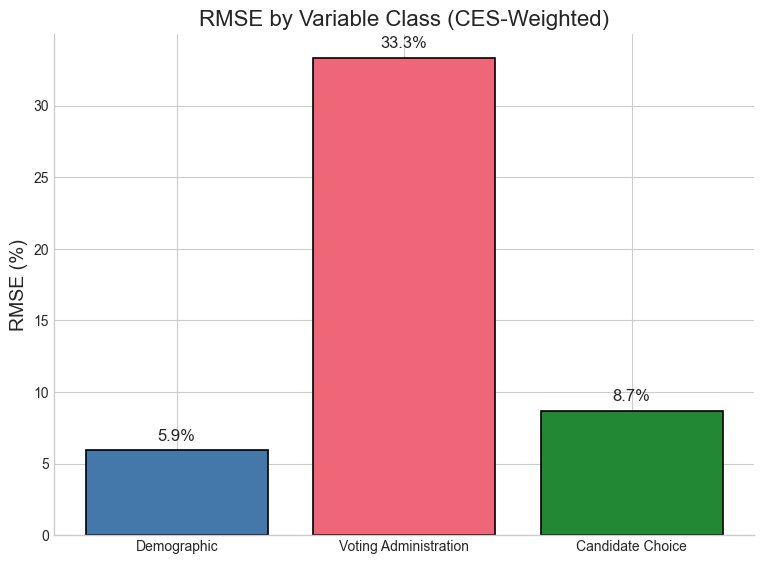

In [10]:
# Calculate RMSE by class
rmse_by_class = df_hist.groupby('Class').apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reindex(class_order)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(rmse_by_class.index, rmse_by_class.values, 
              color=[CLASS_COLORS[c] for c in rmse_by_class.index],
              edgecolor='black', linewidth=1.2)

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('RMSE by Variable Class (Matching + Post-Stratification)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for bar, val in zip(bars, rmse_by_class.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12)

save_figure(fig, 'rmse_by_class_histogram.png')
plt.show()

---
# Primary vs Secondary Comparison

---
# Primary vs Secondary by Year (Stacked Comparison)

Two-panel comparison:
- Top: All variables
- Bottom: Excluding Voter Registration and Voting Turnout

Saved: output/primary_vs_secondary_by_year_stacked.png


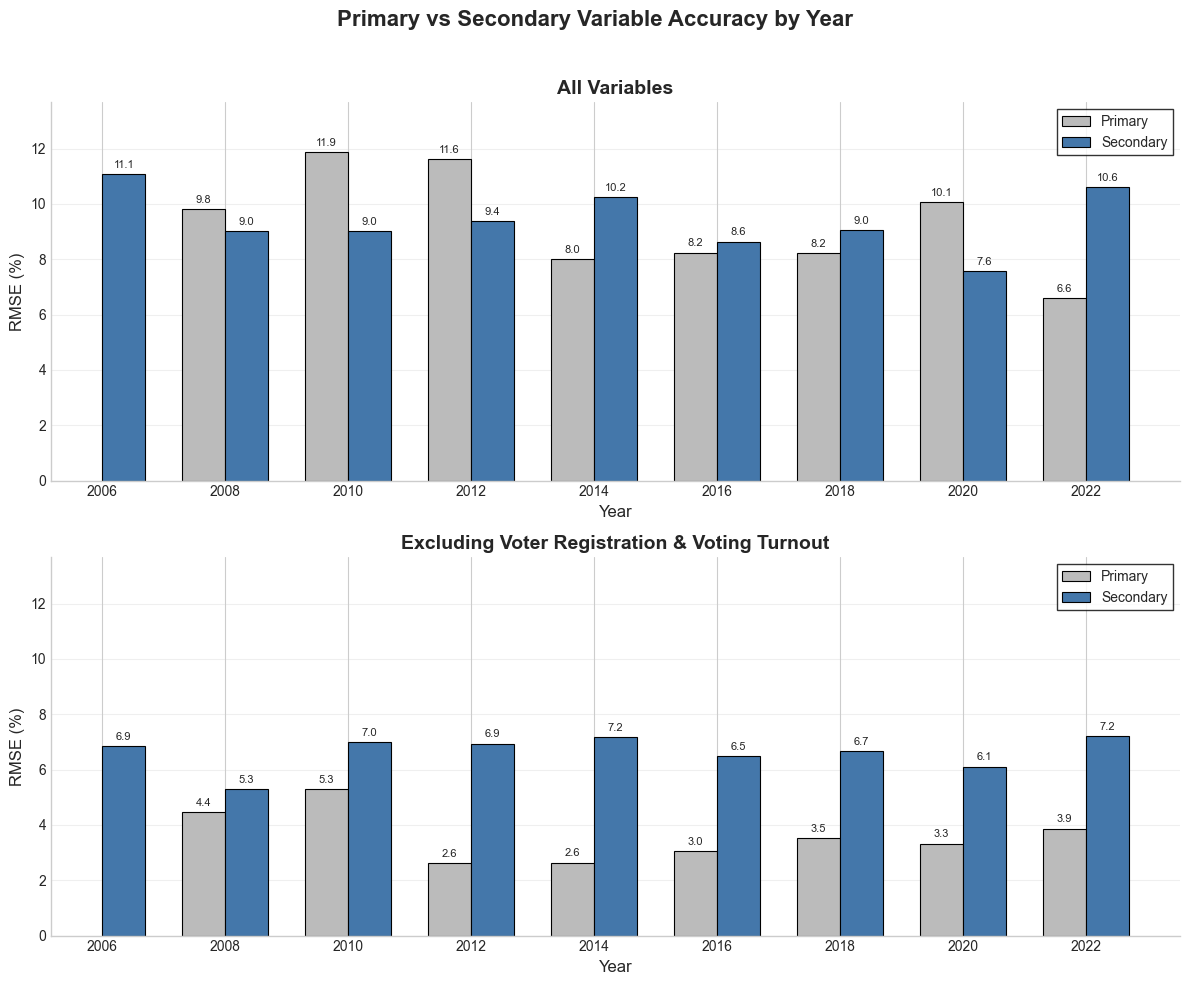


SUMMARY: Primary vs Secondary RMSE by Year (Variable-Level Averaging)

All Variables:
Variable_Type  Primary  Secondary
Year                             
2006               NaN       11.1
2008               9.8        9.0
2010              11.9        9.0
2012              11.6        9.4
2014               8.0       10.2
2016               8.2        8.6
2018               8.2        9.0
2020              10.1        7.6
2022               6.6       10.6

Overall Primary Mean: 9.3
Overall Secondary Mean: 9.4

Excluding Voter Registration & Voting Turnout:
Variable_Type  Primary  Secondary
Year                             
2006               NaN        6.9
2008               4.4        5.3
2010               5.3        7.0
2012               2.6        6.9
2014               2.6        7.2
2016               3.0        6.5
2018               3.5        6.7
2020               3.3        6.1
2022               3.9        7.2

Filtered Primary Mean: 3.6
Filtered Secondary Mean: 6.6
Saved

In [12]:
# =============================================================================
# PRIMARY VS SECONDARY BY YEAR - STACKED COMPARISON
# Top: All variables | Bottom: Excluding Voter Registration & Voting Turnout
# Uses variable-level RMSE averaging (consistent with Table A methodology)
# =============================================================================

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

years = sorted(df_ces['Year'].unique())

# Function to calculate RMSE using variable-level averaging (consistent with Table A)
def calc_rmse_var_avg(data):
    """Calculate RMSE by first computing per-variable RMSE, then averaging."""
    var_rmse = data.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2)))
    return var_rmse.mean()

# Calculate RMSE by Year and Variable Type - ALL variables (variable-level averaging)
rmse_all_data = []
for year in years:
    for vtype in ['Primary', 'Secondary']:
        df_yt = df_ces[(df_ces['Year'] == year) & (df_ces['Variable_Type'] == vtype)]
        if len(df_yt) > 0:
            rmse = calc_rmse_var_avg(df_yt)
            rmse_all_data.append({'Year': year, 'Variable_Type': vtype, 'RMSE': rmse})

rmse_all = pd.DataFrame(rmse_all_data)
rmse_all_pivot = rmse_all.pivot(index='Year', columns='Variable_Type', values='RMSE')

# Calculate RMSE by Year and Variable Type - EXCLUDING voter registration & turnout
exclude_vars = ['Voter Registration', 'Voting Turnout']
df_ces_filtered = df_ces[~df_ces['Variable'].isin(exclude_vars)]

rmse_filtered_data = []
for year in years:
    for vtype in ['Primary', 'Secondary']:
        df_yt = df_ces_filtered[(df_ces_filtered['Year'] == year) & (df_ces_filtered['Variable_Type'] == vtype)]
        if len(df_yt) > 0:
            rmse = calc_rmse_var_avg(df_yt)
            rmse_filtered_data.append({'Year': year, 'Variable_Type': vtype, 'RMSE': rmse})

rmse_filtered = pd.DataFrame(rmse_filtered_data)
rmse_filtered_pivot = rmse_filtered.pivot(index='Year', columns='Variable_Type', values='RMSE')

# Create stacked figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

x = np.arange(len(years))
width = 0.35

# Determine shared y-axis limit
max_val = max(rmse_all_pivot.max().max(), rmse_filtered_pivot.max().max())
y_lim = max_val * 1.15

# Top panel: All variables
bars1_top = ax1.bar(x - width/2, rmse_all_pivot['Primary'], width, 
                    label='Primary', color=VARIABLE_TYPE_COLORS['Primary'], 
                    edgecolor='black', linewidth=0.8)
bars2_top = ax1.bar(x + width/2, rmse_all_pivot['Secondary'], width,
                    label='Secondary', color=VARIABLE_TYPE_COLORS['Secondary'],
                    edgecolor='black', linewidth=0.8)

ax1.set_ylabel('RMSE (%)', fontsize=12)
ax1.set_title('All Variables', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(0, y_lim)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.set_xlabel('Year', fontsize=12)

# Add value labels for top panel
for bar in bars1_top:
    height = bar.get_height()
    if not np.isnan(height):
        ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2_top:
    height = bar.get_height()
    if not np.isnan(height):
        ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Bottom panel: Excluding voter registration & turnout
bars1_bot = ax2.bar(x - width/2, rmse_filtered_pivot['Primary'], width,
                    label='Primary', color=VARIABLE_TYPE_COLORS['Primary'],
                    edgecolor='black', linewidth=0.8)
bars2_bot = ax2.bar(x + width/2, rmse_filtered_pivot['Secondary'], width,
                    label='Secondary', color=VARIABLE_TYPE_COLORS['Secondary'],
                    edgecolor='black', linewidth=0.8)

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('RMSE (%)', fontsize=12)
ax2.set_title('Excluding Voter Registration & Voting Turnout', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, y_lim)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

# Add value labels for bottom panel
for bar in bars1_bot:
    height = bar.get_height()
    if not np.isnan(height):
        ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2_bot:
    height = bar.get_height()
    if not np.isnan(height):
        ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

ax2.set_xticks(x)
ax2.set_xticklabels(years)

fig.suptitle('Primary vs Secondary Variable Accuracy by Year', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

save_figure(fig, 'primary_vs_secondary_by_year_stacked.png', tight=False)
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY: Primary vs Secondary RMSE by Year (Variable-Level Averaging)")
print("="*70)
print("\nAll Variables:")
print(rmse_all_pivot.round(1).to_string())
print(f"\nOverall Primary Mean: {rmse_all_pivot['Primary'].mean():.1f}")
print(f"Overall Secondary Mean: {rmse_all_pivot['Secondary'].mean():.1f}")

print("\nExcluding Voter Registration & Voting Turnout:")
print(rmse_filtered_pivot.round(1).to_string())
print(f"\nFiltered Primary Mean: {rmse_filtered_pivot['Primary'].mean():.1f}")
print(f"Filtered Secondary Mean: {rmse_filtered_pivot['Secondary'].mean():.1f}")

# =============================================================================
# PRIMARY VS SECONDARY DELTA TABLE BY CLASS AND YEAR
# =============================================================================

# Calculate deltas (Secondary - Primary)
delta_data = []
for year in years:
    for cls in class_order:
        df_year_class = df_ces[(df_ces['Year'] == year) & (df_ces['Class'] == cls)]
        
        df_primary = df_year_class[df_year_class['Variable_Type'] == 'Primary']
        df_secondary = df_year_class[df_year_class['Variable_Type'] == 'Secondary']
        
        rmse_primary = calc_rmse_var_avg(df_primary)
        rmse_secondary = calc_rmse_var_avg(df_secondary)
        
        if pd.isna(rmse_primary) or pd.isna(rmse_secondary):
            delta = np.nan
        else:
            delta = rmse_secondary - rmse_primary
        
        delta_data.append({'Year': year, 'Class': cls, 'Delta': delta})

delta_df = pd.DataFrame(delta_data)

# =============================================================================
# CREATE PRIMARY VS SECONDARY DELTA TABLE
# Excluding Turnout & Registration (and thus Voting Administration class)
# =============================================================================

def calc_class_delta(data, cls):
    """Calculate delta between Secondary and Primary RMSE for a class."""
    df_cls = data[data['Class'] == cls]
    df_primary = df_cls[df_cls['Variable_Type'] == 'Primary']
    df_secondary = df_cls[df_cls['Variable_Type'] == 'Secondary']
    
    if len(df_primary) == 0 or len(df_secondary) == 0:
        return np.nan
    
    rmse_primary = df_primary.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2))).mean()
    rmse_secondary = df_secondary.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2))).mean()
    
    return rmse_secondary - rmse_primary

def calc_overall_delta(data):
    """Calculate overall delta between Secondary and Primary RMSE."""
    df_primary = data[data['Variable_Type'] == 'Primary']
    df_secondary = data[data['Variable_Type'] == 'Secondary']
    
    if len(df_primary) == 0 or len(df_secondary) == 0:
        return np.nan
    
    rmse_primary = df_primary.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2))).mean()
    rmse_secondary = df_secondary.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2))).mean()
    
    return rmse_secondary - rmse_primary

# Calculate deltas EXCLUDING Turnout & Registration
exclude_vars = ['Voter Registration', 'Voting Turnout']
df_ces_excl = df_ces[~df_ces['Variable'].isin(exclude_vars)]

# Classes to include (excluding Voting Administration since it only has Turnout/Registration)
classes_to_show = ['Demographic', 'Candidate Choice']

delta_excl = {}
for year in years:
    delta_excl[year] = {}
    df_year = df_ces_excl[df_ces_excl['Year'] == year]
    for cls in classes_to_show:
        delta_excl[year][cls] = calc_class_delta(df_year, cls)
    delta_excl[year]['Overall'] = calc_overall_delta(df_year)

# Build LaTeX table
latex_lines = []
latex_lines.append("\\begin{table}[!htbp]")
latex_lines.append("\\centering")
latex_lines.append("\\footnotesize")
latex_lines.append("\\caption{RMSE Delta Between Secondary and Primary Variables by Year}")
latex_lines.append("\\label{tab:primary_secondary_delta}")
latex_lines.append("\\begin{threeparttable}")

col_format = "l" + "c" * len(years)
latex_lines.append("\\begin{tabular}{" + col_format + "}")
latex_lines.append("\\toprule")

# Header row
header_parts = ["Variable Class"] + [str(int(y)) for y in years]
latex_lines.append(" & ".join(header_parts) + " \\\\")
latex_lines.append("\\midrule")

def format_delta(val):
    if pd.isna(val):
        return "-"
    elif val >= 0:
        return f"+{val:.1f}"
    else:
        return f"{val:.1f}"

for cls in classes_to_show:
    row_parts = [cls]
    for year in years:
        row_parts.append(format_delta(delta_excl[year].get(cls, np.nan)))
    latex_lines.append(" & ".join(row_parts) + " \\\\")

# Overall row
row_parts = ["\\textbf{Overall}"]
for year in years:
    row_parts.append(format_delta(delta_excl[year].get('Overall', np.nan)))
latex_lines.append(" & ".join(row_parts) + " \\\\")

latex_lines.append("\\bottomrule")
latex_lines.append("\\end{tabular}")
latex_lines.append("\\begin{tablenotes}")
latex_lines.append("\\footnotesize")
latex_lines.append("\\item \\textit{Note:} Delta = Secondary RMSE - Primary RMSE (excluding Voter Turnout and Registration). Positive values indicate Secondary variables have higher error.")
latex_lines.append("\\end{tablenotes}")
latex_lines.append("\\end{threeparttable}")
latex_lines.append("\\end{table}")

latex_delta_str = "\n".join(latex_lines)

with open('output/primary_secondary_delta.tex', 'w') as f:
    f.write(latex_delta_str)
print("Saved: output/primary_secondary_delta.tex")

# =============================================================================
# PLOT: Primary vs Secondary Delta by Year (Excluding Turnout & Registration)
# =============================================================================

# Prepare data for plotting - Overall only
plot_years = sorted(delta_excl.keys())
overall_deltas = [delta_excl[y]['Overall'] for y in plot_years]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(plot_years))
width = 0.6

# Plot bars for overall delta
bars = ax.bar(x, overall_deltas, width, color='#4477AA', edgecolor='black', linewidth=0.8)

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Delta (Secondary - Primary RMSE)', fontsize=12)
ax.set_title('Primary vs Secondary RMSE Delta by Year\n(Excluding Voter Turnout & Registration)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([str(int(y)) for y in plot_years])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        va = 'bottom' if height >= 0 else 'top'
        ax.annotate(f'{height:+.1f}', 
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3 if height >= 0 else -3), 
                   textcoords="offset points",
                   ha='center', va=va, fontsize=9, fontweight='bold')

plt.tight_layout()
save_figure(fig, 'primary_secondary_delta_by_year.png')
plt.show()

print("\nDelta Summary (Excluding Turnout & Registration):")
for year in plot_years:
    print(f"{year}: Overall={delta_excl[year]['Overall']:+.1f}")


---
# Consistent Primary vs Secondary Comparison

Analysis comparing variables that are **consistently Primary or Secondary across all years** and **present in every survey year**.

This addresses the limitation that some variables change status between years (e.g., Voting Turnout is Primary 2008-2012 but Secondary 2014+).

- **Consistent Primary**: Variables that are Primary in every year AND present in every year
- **Consistent Secondary**: Variables that are Secondary in every year AND present in every year

In [ ]:
# =============================================================================
# CONSISTENT PRIMARY VS SECONDARY BY YEAR (ALL YEARS)
# Only includes variables that are consistently Primary/Secondary in ALL years
# AND present in every survey year
# =============================================================================

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years = sorted(all_years)

# Identify variables that are consistently Primary/Secondary AND present in ALL years
always_primary = []
always_secondary = []

for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    
    # Must be present in ALL years
    if years_present != all_years:
        continue
    
    # Check Variable_Type per year - must be consistent
    types_by_year = var_data.groupby('Year')['Variable_Type'].first().to_dict()
    unique_types = set(types_by_year.values())
    
    if len(unique_types) == 1:
        if 'Primary' in unique_types:
            always_primary.append(var)
        elif 'Secondary' in unique_types:
            always_secondary.append(var)

print(f"Consistent Primary variables (all years): {always_primary}")
print(f"Consistent Secondary variables (all years): {always_secondary}")
print()

# Calculate RMSE by Year for consistent variables only
def calc_rmse_var_avg(data):
    """Calculate RMSE by first computing per-variable RMSE, then averaging."""
    if len(data) == 0:
        return np.nan
    var_rmse = data.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2)))
    return var_rmse.mean()

rmse_data = []
for year in years:
    # Primary
    if len(always_primary) > 0:
        df_primary = df_ces[(df_ces['Year'] == year) & (df_ces['Variable'].isin(always_primary))]
        rmse_p = calc_rmse_var_avg(df_primary)
        rmse_data.append({'Year': year, 'Variable_Type': 'Primary', 'RMSE': rmse_p})
    
    # Secondary
    if len(always_secondary) > 0:
        df_secondary = df_ces[(df_ces['Year'] == year) & (df_ces['Variable'].isin(always_secondary))]
        rmse_s = calc_rmse_var_avg(df_secondary)
        rmse_data.append({'Year': year, 'Variable_Type': 'Secondary', 'RMSE': rmse_s})

rmse_df = pd.DataFrame(rmse_data)
rmse_pivot = rmse_df.pivot(index='Year', columns='Variable_Type', values='RMSE')

print("RMSE by Year (Consistent Variables Only):")
print(rmse_pivot.round(1).to_string())
print()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))
width = 0.35

# Handle case where no always-primary variables exist
has_primary = 'Primary' in rmse_pivot.columns and not rmse_pivot['Primary'].isna().all()
has_secondary = 'Secondary' in rmse_pivot.columns and not rmse_pivot['Secondary'].isna().all()

if has_primary and has_secondary:
    bars1 = ax.bar(x - width/2, rmse_pivot['Primary'], width, 
                   label=f'Consistent Primary (n={len(always_primary)})', 
                   color=VARIABLE_TYPE_COLORS['Primary'], 
                   edgecolor='black', linewidth=0.8)
    bars2 = ax.bar(x + width/2, rmse_pivot['Secondary'], width,
                   label=f'Consistent Secondary (n={len(always_secondary)})',
                   color=VARIABLE_TYPE_COLORS['Secondary'],
                   edgecolor='black', linewidth=0.8)
    all_bars = [bars1, bars2]
elif has_secondary:
    bars2 = ax.bar(x, rmse_pivot['Secondary'], width,
                   label=f'Consistent Secondary (n={len(always_secondary)})',
                   color=VARIABLE_TYPE_COLORS['Secondary'],
                   edgecolor='black', linewidth=0.8)
    all_bars = [bars2]
    # Add note about no primary variables
    ax.text(0.5, 0.95, 'Note: No variables are consistently Primary across all years (including 2006)',
            transform=ax.transAxes, ha='center', va='top', fontsize=10, style='italic',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
elif has_primary:
    bars1 = ax.bar(x, rmse_pivot['Primary'], width, 
                   label=f'Consistent Primary (n={len(always_primary)})', 
                   color=VARIABLE_TYPE_COLORS['Primary'], 
                   edgecolor='black', linewidth=0.8)
    all_bars = [bars1]

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('RMSE (%)', fontsize=12)
ax.set_title('Consistent Primary vs Secondary Variable Accuracy by Year (All Years)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels(years)

# Add value labels
for bars in all_bars:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_figure(fig, 'primary_vs_secondary_consistent_all_years.png')
plt.show()

# Print variable details
print("="*70)
print("CONSISTENT VARIABLE DETAILS")
print("="*70)
if len(always_primary) > 0:
    print(f"\nConsistent Primary ({len(always_primary)} variables):")
    for v in sorted(always_primary):
        cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
        print(f"  - {v} ({cls})")
else:
    print("\nConsistent Primary: None (all Primary variables were Secondary in 2006)")

print(f"\nConsistent Secondary ({len(always_secondary)} variables):")
for v in sorted(always_secondary):
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

In [ ]:
# =============================================================================
# CONSISTENT PRIMARY VS SECONDARY BY YEAR (EXCLUDING 2006)
# Only includes variables that are consistently Primary/Secondary in 2008-2022
# AND present in every survey year from 2008 onwards
# Excludes 2006 since all variables were Secondary in that year
# =============================================================================

# Get CES-weighted data excluding 2006
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Year'] != 2006)
].copy()

all_years_excl_2006 = set(df_ces['Year'].unique())
years = sorted(all_years_excl_2006)

print(f"Years included: {years}")
print()

# Identify variables that are consistently Primary/Secondary AND present in ALL years (excl 2006)
always_primary = []
always_secondary = []

for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    
    # Must be present in ALL years (excluding 2006)
    if years_present != all_years_excl_2006:
        continue
    
    # Check Variable_Type per year - must be consistent
    types_by_year = var_data.groupby('Year')['Variable_Type'].first().to_dict()
    unique_types = set(types_by_year.values())
    
    if len(unique_types) == 1:
        if 'Primary' in unique_types:
            always_primary.append(var)
        elif 'Secondary' in unique_types:
            always_secondary.append(var)

print(f"Consistent Primary variables (2008-2022): {always_primary}")
print(f"Consistent Secondary variables (2008-2022): {always_secondary}")
print()

# Calculate RMSE by Year for consistent variables only
def calc_rmse_var_avg(data):
    """Calculate RMSE by first computing per-variable RMSE, then averaging."""
    if len(data) == 0:
        return np.nan
    var_rmse = data.groupby('Variable')['Error'].apply(lambda x: np.sqrt(np.mean(x**2)))
    return var_rmse.mean()

rmse_data = []
for year in years:
    # Primary
    if len(always_primary) > 0:
        df_primary = df_ces[(df_ces['Year'] == year) & (df_ces['Variable'].isin(always_primary))]
        rmse_p = calc_rmse_var_avg(df_primary)
        rmse_data.append({'Year': year, 'Variable_Type': 'Primary', 'RMSE': rmse_p})
    
    # Secondary
    if len(always_secondary) > 0:
        df_secondary = df_ces[(df_ces['Year'] == year) & (df_ces['Variable'].isin(always_secondary))]
        rmse_s = calc_rmse_var_avg(df_secondary)
        rmse_data.append({'Year': year, 'Variable_Type': 'Secondary', 'RMSE': rmse_s})

rmse_df = pd.DataFrame(rmse_data)
rmse_pivot = rmse_df.pivot(index='Year', columns='Variable_Type', values='RMSE')

print("RMSE by Year (Consistent Variables Only, 2008-2022):")
print(rmse_pivot.round(1).to_string())
print()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))
width = 0.35

bars1 = ax.bar(x - width/2, rmse_pivot['Primary'], width, 
               label=f'Consistent Primary (n={len(always_primary)})', 
               color=VARIABLE_TYPE_COLORS['Primary'], 
               edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, rmse_pivot['Secondary'], width,
               label=f'Consistent Secondary (n={len(always_secondary)})',
               color=VARIABLE_TYPE_COLORS['Secondary'],
               edgecolor='black', linewidth=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('RMSE (%)', fontsize=12)
ax.set_title('Consistent Primary vs Secondary Variable Accuracy by Year (2008-2022)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels(years)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_figure(fig, 'primary_vs_secondary_consistent_excl_2006.png')
plt.show()

# Print variable details
print("="*70)
print("CONSISTENT VARIABLE DETAILS (2008-2022)")
print("="*70)
print(f"\nConsistent Primary ({len(always_primary)} variables):")
for v in sorted(always_primary):
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

print(f"\nConsistent Secondary ({len(always_secondary)} variables):")
for v in sorted(always_secondary):
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

# Summary comparison
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
if 'Primary' in rmse_pivot.columns:
    print(f"Mean RMSE - Consistent Primary: {rmse_pivot['Primary'].mean():.1f}%")
print(f"Mean RMSE - Consistent Secondary: {rmse_pivot['Secondary'].mean():.1f}%")
if 'Primary' in rmse_pivot.columns:
    diff = rmse_pivot['Secondary'].mean() - rmse_pivot['Primary'].mean()
    print(f"Difference (Secondary - Primary): {diff:+.1f}%")

---
# Error Trends Over Time

In [ ]:
# =============================================================================
# PRIMARY ANALYSIS: RMSE TRENDS OVER TIME
# =============================================================================
# Step 1: Estimand = RMSE trend
# Step 2: Aggregate to year × variable level (SECONDARY VARIABLES ONLY, ALL YEARS)
# Step 3: OLS with variable fixed effects
# Step 4: Robust inference (HC3 SEs + permutation test)
# =============================================================================

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Filter for Matching + Post-Stratification, All validity scheme
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())

# =============================================================================
# IDENTIFY ALWAYS-SECONDARY VARIABLES PRESENT IN ALL YEARS
# =============================================================================
always_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary.append(var)

print("="*80)
print("ALWAYS-SECONDARY VARIABLES (present in all years)")
print("="*80)
print(f"Variables: {always_secondary}")
print(f"N variables: {len(always_secondary)}")

# Filter to these variables only
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary)].copy()

# =============================================================================
# STEP 2: Aggregate to year × variable level
# =============================================================================
def compute_rmse(errors):
    return np.sqrt(np.mean(errors ** 2))

agg_data = df_secondary.groupby(['Year', 'Variable', 'Class']).agg(
    RMSE=('Error', lambda x: compute_rmse(x)),
    MAE=('Error', lambda x: np.mean(np.abs(x))),
    N=('Error', 'count')
).reset_index()

center_year = agg_data['Year'].median()
agg_data['Year_centered'] = agg_data['Year'] - center_year

print()
print("="*80)
print("AGGREGATED DATA: Year × Variable Level (Secondary Only)")
print("="*80)
print(f"N observations (year × variable): {len(agg_data)}")
print(f"N years: {agg_data['Year'].nunique()}")
print(f"N variables: {agg_data['Variable'].nunique()}")
print(f"Center year: {center_year}")

# =============================================================================
# STEP 3: OLS with variable fixed effects
# =============================================================================
model = smf.ols("RMSE ~ Year_centered + C(Variable)", data=agg_data)
result_ols = model.fit()
result_hc3 = model.fit(cov_type='HC3')

beta = result_hc3.params['Year_centered']
beta_se = result_hc3.bse['Year_centered']
beta_pval = result_hc3.pvalues['Year_centered']
beta_ci = result_hc3.conf_int().loc['Year_centered']

print()
print("="*80)
print("PRIMARY MODEL: RMSE ~ Year + Variable FE (HC3 Robust SEs)")
print("="*80)
print(f"Year slope (β): {beta:.4f}% RMSE per year")
print(f"Robust SE (HC3): {beta_se:.4f}")
print(f"t-statistic: {beta/beta_se:.3f}")
print(f"p-value: {beta_pval:.4f} {'***' if beta_pval < 0.001 else '**' if beta_pval < 0.01 else '*' if beta_pval < 0.05 else ''}")
print(f"95% CI: [{beta_ci[0]:.4f}, {beta_ci[1]:.4f}]")
print(f"R² (with variable FE): {result_hc3.rsquared:.4f}")

# =============================================================================
# STEP 4: Permutation test
# =============================================================================
print()
print("="*80)
print("PERMUTATION TEST (10,000 permutations of year labels)")
print("="*80)

np.random.seed(42)
n_perms = 10000
observed_beta = beta

perm_betas = []
years = agg_data['Year'].unique()

for _ in range(n_perms):
    year_mapping = dict(zip(years, np.random.permutation(years)))
    agg_perm = agg_data.copy()
    agg_perm['Year_perm'] = agg_perm['Year'].map(year_mapping)
    agg_perm['Year_centered_perm'] = agg_perm['Year_perm'] - center_year
    
    model_perm = smf.ols("RMSE ~ Year_centered_perm + C(Variable)", data=agg_perm)
    result_perm = model_perm.fit()
    perm_betas.append(result_perm.params['Year_centered_perm'])

perm_betas = np.array(perm_betas)
perm_pval = np.mean(np.abs(perm_betas) >= np.abs(observed_beta))

print(f"Observed β: {observed_beta:.4f}")
print(f"Permutation p-value (two-sided): {perm_pval:.4f}")

# =============================================================================
# ROBUSTNESS: Individual-level with year-clustered SEs
# =============================================================================
print()
print("="*80)
print("ROBUSTNESS: Individual-level with year-clustered SEs")
print("="*80)

df_secondary['SqError'] = df_secondary['Error'] ** 2
df_secondary['Year_centered'] = df_secondary['Year'] - center_year

model_indiv = smf.ols("SqError ~ Year_centered + C(Variable)", data=df_secondary)
result_indiv = model_indiv.fit(cov_type='cluster', cov_kwds={'groups': df_secondary['Year']})

beta_indiv = result_indiv.params['Year_centered']
beta_se_indiv = result_indiv.bse['Year_centered']
beta_pval_indiv = result_indiv.pvalues['Year_centered']

print(f"Year slope (β): {beta_indiv:.4f} (squared error units)")
print(f"Cluster-robust SE: {beta_se_indiv:.4f}")
print(f"p-value: {beta_pval_indiv:.4f}")

# =============================================================================
# SUMMARY
# =============================================================================
print()
print("="*80)
print("SUMMARY: RMSE TREND ANALYSIS (Secondary Variables Only)")
print("="*80)
print(f"{'Method':<45} {'β':<12} {'SE':<12} {'p-value':<12}")
print("-"*80)
print(f"{'Primary: Aggregated OLS + HC3':<45} {beta:<12.4f} {beta_se:<12.4f} {beta_pval:<12.4f}")
print(f"{'Primary: Permutation test':<45} {observed_beta:<12.4f} {'-':<12} {perm_pval:<12.4f}")
print(f"{'Robustness: Individual + Year-clustered':<45} {beta_indiv:<12.4f} {beta_se_indiv:<12.4f} {beta_pval_indiv:<12.4f}")

# =============================================================================
# VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
years_list = sorted(agg_data['Year'].unique())
year_rmse = agg_data.groupby('Year')['RMSE'].mean()

ax1.scatter(years_list, [year_rmse[y] for y in years_list], s=120, color='#3366BB', 
            edgecolor='black', linewidth=1.5, zorder=5, label='Mean RMSE (across variables)')

year_range = np.array([min(years_list), max(years_list)])
year_range_centered = year_range - center_year
intercept = result_hc3.params['Intercept']
trend_line = intercept + beta * year_range_centered
ax1.plot(year_range, trend_line, '--', color='#DD3333', linewidth=2.5, 
         label=f'OLS Trend (β={beta:.3f}/yr, p={beta_pval:.3f})')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('RMSE (%)', fontsize=12)
ax1.set_title('Primary Analysis: RMSE Trends Over Time\n(Secondary Variables Only, HC3 Robust SEs)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax1.set_xticks(years_list)
ax1.set_xticklabels([str(y) for y in years_list], rotation=45)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

ax2 = axes[1]
ax2.hist(perm_betas, bins=50, color='#888888', edgecolor='black', alpha=0.7, label='Null distribution')
ax2.axvline(observed_beta, color='#DD3333', linewidth=2.5, linestyle='--', label=f'Observed β = {observed_beta:.3f}')
ax2.axvline(-observed_beta, color='#DD3333', linewidth=2.5, linestyle='--', alpha=0.5)
ax2.axvline(np.percentile(perm_betas, 2.5), color='black', linewidth=1, linestyle=':', label='95% null CI')
ax2.axvline(np.percentile(perm_betas, 97.5), color='black', linewidth=1, linestyle=':')

ax2.set_xlabel('Year Coefficient (β)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Permutation Test (n=10,000)\nTwo-sided p = {perm_pval:.4f}', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig, 'rmse_trend_primary_analysis.png')
plt.show()

print("\nSaved: output/rmse_trend_primary_analysis.png")

Always-secondary variables present in all years (8):
  - State Representative (Candidate Choice)
  - State Senator (Candidate Choice)
  - U.S. House (Candidate Choice)
  - Employment Status (Demographic)
  - Family Income (Demographic)
  - Union Membership (Demographic)
  - Veteran Status (Demographic)
  - Voting Method (Voting Administration)

RMSE by Class and Year:
Class  All  Candidate Choice  Demographic  Voting Administration
Year                                                            
2006   6.2               7.9          5.5                    3.7
2008   7.0               8.2          6.1                    4.3
2010   8.5              10.2          6.8                    6.0
2012   8.8               9.4          7.9                    4.5
2014   8.5               9.3          7.0                    3.4
2016   8.6               9.3          7.3                    5.4
2018   8.7               9.4          7.4                    5.0
2020   7.9               8.0          7.9   

Saved: output/rmse_trends_always_secondary.png


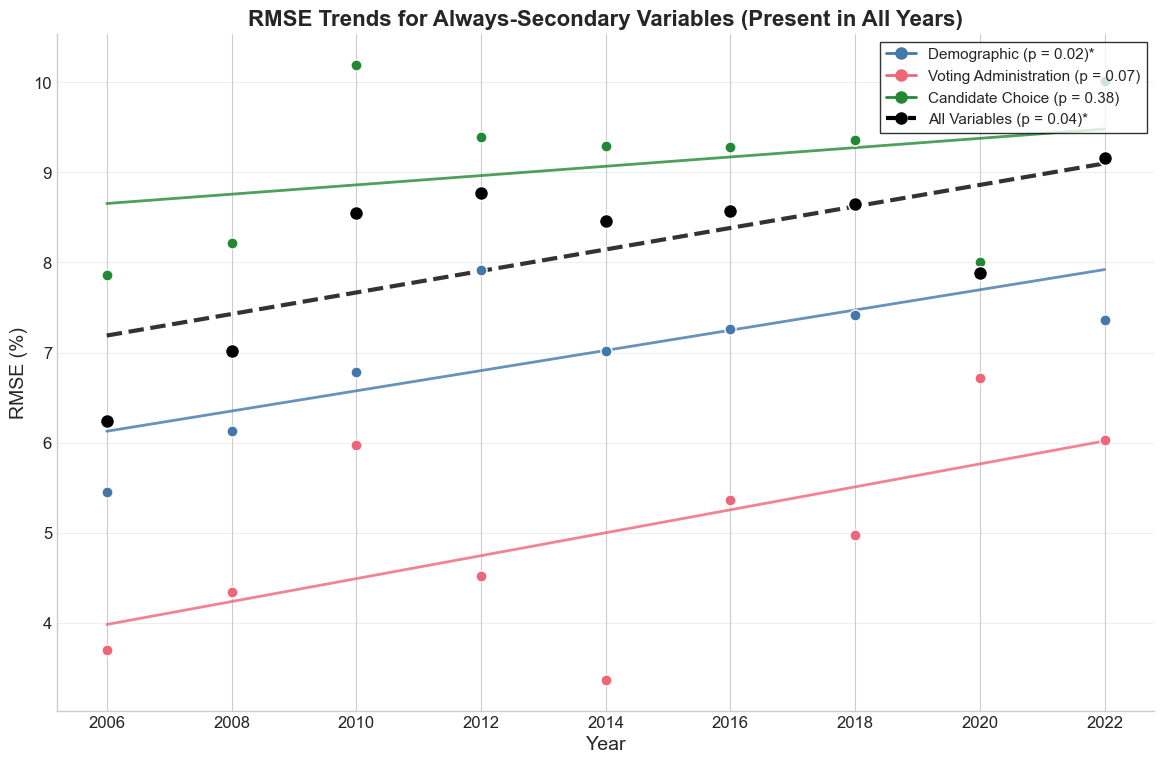

In [14]:
# =============================================================================
# RMSE TRENDS FOR ALWAYS-SECONDARY VARIABLES (PRESENT IN ALL YEARS)
# Variables that are Secondary in ALL years AND present in every survey year
# =============================================================================

# Get all years in the dataset
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())

# Identify always-secondary variables that are PRESENT IN ALL YEARS
always_secondary_all_years = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary_all_years.append(var)

print(f"Always-secondary variables present in all years ({len(always_secondary_all_years)}):")
for v in always_secondary_all_years:
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

# Filter to these variables only
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary_all_years)].copy()

# Calculate RMSE by Year and Class
rmse_by_class_year = df_secondary.groupby(['Year', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Calculate overall RMSE by Year (all classes combined)
rmse_all_year = df_secondary.groupby('Year').apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')
rmse_all_year['Class'] = 'All'

# Combine
rmse_combined = pd.concat([rmse_by_class_year, rmse_all_year], ignore_index=True)

print("\nRMSE by Class and Year:")
print(rmse_combined.pivot(index='Year', columns='Class', values='RMSE').round(1).to_string())

# Color scheme with All
colors_with_all = {**CLASS_COLORS, 'All': '#000000'}

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

years = sorted(df_secondary['Year'].unique())
classes = ['Demographic', 'Voting Administration', 'Candidate Choice', 'All']

# Store regression results for legend
legend_entries = []

print("\n" + "="*60)
print("REGRESSION RESULTS")
print("="*60)

for cls in classes:
    cls_data = rmse_combined[rmse_combined['Class'] == cls].sort_values('Year')
    
    if len(cls_data) < 2:
        continue
    
    x = cls_data['Year'].values
    y = cls_data['RMSE'].values
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Format p-value for legend
    if p_value < 0.001:
        p_str = 'p < 0.001'
    elif p_value < 0.01:
        p_str = f'p = {p_value:.3f}'
    else:
        p_str = f'p = {p_value:.2f}'
    
    # Significance marker
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    color = colors_with_all[cls]
    linewidth = 3 if cls == 'All' else 2
    markersize = 10 if cls == 'All' else 8
    linestyle = '-' if cls != 'All' else '--'
    
    # Plot data points
    ax.scatter(x, y, color=color, s=markersize**2, zorder=5, edgecolors='white', linewidth=1)
    
    # Plot regression line
    x_line = np.array([min(years), max(years)])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=color, linewidth=linewidth, linestyle=linestyle, alpha=0.8)
    
    # Legend label with p-value
    if cls == 'All':
        label = f'All Variables ({p_str}){sig}'
    else:
        label = f'{cls} ({p_str}){sig}'
    
    legend_entries.append((plt.Line2D([0], [0], color=color, linewidth=linewidth, 
                                       linestyle=linestyle, marker='o', markersize=8), label))
    
    print(f"\n{cls}:")
    print(f"  Slope: {slope:.3f} RMSE/year")
    print(f"  p-value: {p_value:.4f} {sig}")
    print(f"  R²: {r_value**2:.3f}")

# Styling
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('RMSE Trends for Always-Secondary Variables (Present in All Years)', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='-', alpha=0.3)

# Custom legend
lines, labels = zip(*legend_entries)
ax.legend(lines, labels, loc='upper right', fontsize=11, frameon=True, 
          fancybox=False, edgecolor='black')

save_figure(fig, 'rmse_trends_always_secondary.png')
plt.show()

In [ ]:
# =============================================================================# RMSE TRENDS BY INDIVIDUAL ALWAYS-SECONDARY VARIABLE (WINSORIZED 95/5)# One line per variable with regression line and p-value# Uses 95/5 winsorized RMSE to reduce impact of outliers# =============================================================================# Get CES-weighted datadf_ces = most_specific[    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &    (most_specific['Validity_Scheme'] == 'All')].copy()all_years = set(df_ces['Year'].unique())years = sorted(all_years)# Identify always-secondary variables present in all yearsalways_secondary = []for var in df_ces['Variable'].unique():    var_data = df_ces[df_ces['Variable'] == var]    years_present = set(var_data['Year'].unique())    types = var_data['Variable_Type'].unique()    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'    is_all_years = years_present == all_years    if is_always_secondary and is_all_years:        always_secondary.append(var)print(f"Always-secondary variables: {always_secondary}")# Filter to these variablesdf_secondary = df_ces[df_ces['Variable'].isin(always_secondary)].copy()# Calculate WINSORIZED RMSE by Year and Variable (95/5)from scipy.stats.mstats import winsorizedef calculate_winsorized_rmse(errors, limits=(0.05, 0.05)):    """Calculate RMSE after winsorizing at specified limits."""    winsorized_errors = winsorize(errors, limits=limits)    return np.sqrt(np.mean(winsorized_errors**2))rmse_by_var_year = df_secondary.groupby(['Year', 'Variable']).apply(    lambda x: calculate_winsorized_rmse(x['Error']), include_groups=False).reset_index(name='RMSE')# Get class for each variable (for coloring)var_to_class = df_secondary.groupby('Variable')['Class'].first().to_dict()# Create color palette with enough distinct colorsn_vars = len(always_secondary)cmap = plt.cm.get_cmap('tab20', n_vars)var_colors = {var: cmap(i) for i, var in enumerate(sorted(always_secondary))}# Create figurefig, ax = plt.subplots(figsize=(14, 9))# Store regression results for tableregression_results = []print("\n" + "="*70)print("REGRESSION RESULTS BY VARIABLE (Winsorized RMSE)")print("="*70)for var in sorted(always_secondary):    var_data = rmse_by_var_year[rmse_by_var_year['Variable'] == var].sort_values('Year')    if len(var_data) < 2:        continue    x = var_data['Year'].values    y = var_data['RMSE'].values    # Linear regression    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)    # Store results    cls = var_to_class[var]    # Significance marker    if p_value < 0.001:        sig = '***'    elif p_value < 0.01:        sig = '**'    elif p_value < 0.05:        sig = '*'    else:        sig = ''    regression_results.append({        'Variable': var,        'Variable_Starred': var + sig,        'Slope': slope,        'p_value': p_value,        'sig': sig,        'Class': cls    })    color = var_colors[var]    # Plot data points    ax.scatter(x, y, color=color, s=60, zorder=5, edgecolors='white', linewidth=0.5, alpha=0.9)    # Plot regression line    x_line = np.array([min(years), max(years)])    y_line = slope * x_line + intercept    ax.plot(x_line, y_line, color=color, linewidth=2, alpha=0.7, label=f'{var} {sig}')    print(f"\n{var} ({cls}):")    print(f"  Slope: {slope:.4f} RMSE/year")    print(f"  p-value: {p_value:.4f} {sig}")# Stylingax.set_xlabel('Year', fontsize=14)ax.set_ylabel('Winsorized RMSE (%) [95/5]', fontsize=14)ax.set_title('RMSE Trends by Individual Always-Secondary Variable (Winsorized 95/5)', fontsize=16, fontweight='bold')ax.spines['top'].set_visible(False)ax.spines['right'].set_visible(False)ax.set_xticks(years)ax.set_xticklabels(years, rotation=0)ax.tick_params(axis='both', labelsize=12)ax.grid(axis='y', linestyle='-', alpha=0.3)# Legend outside plotax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10,          frameon=True, fancybox=False, edgecolor='black')plt.tight_layout()save_figure(fig, 'rmse_trends_by_variable_winsorized.png', tight=False)plt.show()# Create and save regression results tablereg_df = pd.DataFrame(regression_results)reg_df = reg_df.sort_values('p_value')print("\n" + "="*70)print("REGRESSION TABLE (sorted by p-value)")print("="*70)print(reg_df[['Variable_Starred', 'Slope', 'p_value']].to_string(index=False))# Create LaTeX table with starred variableslatex_table = []latex_table.append(r"\begin{table}[!htbp]")latex_table.append(r"\centering")latex_table.append(r"\footnotesize")latex_table.append(r"\caption{RMSE Trend Regression by Variable (Winsorized 95/5)}")latex_table.append(r"\label{tab:rmse_trend_regression_by_variable}")latex_table.append(r"\begin{threeparttable}")latex_table.append(r"\begin{tabular}{lcc}")latex_table.append(r"\toprule")latex_table.append(r"Variable & Slope & p-value \\")latex_table.append(r"\midrule")for _, row in reg_df.iterrows():    var_name = row['Variable']    if row['sig']:        var_name = var_name + r"$^{" + row['sig'] + r"}$"    slope_str = f"{row['Slope']:.3f}"    p_str = f"{row['p_value']:.3f}" if row['p_value'] >= 0.001 else "<0.001"    latex_table.append(f"{var_name} & {slope_str} & {p_str} \\\\")latex_table.append(r"\bottomrule")latex_table.append(r"\end{tabular}")latex_table.append(r"\begin{tablenotes}")latex_table.append(r"\footnotesize")latex_table.append(r"\item \textit{Note:} Linear regression of winsorized RMSE (95/5) over time for always-secondary variables. * p<0.05, ** p<0.01, *** p<0.001.")latex_table.append(r"\end{tablenotes}")latex_table.append(r"\end{threeparttable}")latex_table.append(r"\end{table}")latex_str = "\n".join(latex_table)with open('output/rmse_trend_regression_by_variable.tex', 'w') as f:    f.write(latex_str)print("\nSaved: output/rmse_trend_regression_by_variable.tex")# Save to Excelreg_df[['Variable', 'Slope', 'p_value']].to_excel('output/rmse_trend_regression_by_variable.xlsx', index=False)print("Saved: output/rmse_trend_regression_by_variable.xlsx")

In [ ]:
# =============================================================================
# DISAGGREGATED ERROR TRENDS BY CLASS
# All individual errors as faint scatter, regression lines by class
# =============================================================================

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years = sorted(all_years)

# Identify always-secondary variables present in all years
always_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary.append(var)

# Filter to these variables
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary)].copy()

# Use absolute error for visualization
df_secondary['Abs_Error'] = df_secondary['Error'].abs()

# Get unique classes
classes = df_secondary['Class'].unique()

# Create figure
fig, ax = plt.subplots(figsize=(14, 9))

# Store regression results for table
regression_results = []

print("="*70)
print("DISAGGREGATED REGRESSION RESULTS BY CLASS")
print("="*70)

# Add small jitter to years for scatter visibility
np.random.seed(42)

for cls in ['Demographic', 'Voting Administration', 'Candidate Choice']:
    cls_data = df_secondary[df_secondary['Class'] == cls].copy()
    
    if len(cls_data) < 2:
        continue
    
    # Add jitter to x for scatter
    jitter = np.random.uniform(-0.2, 0.2, len(cls_data))
    x_jittered = cls_data['Year'].values + jitter
    
    x = cls_data['Year'].values
    y = cls_data['Abs_Error'].values
    
    color = CLASS_COLORS[cls]
    
    # Plot scatter (faint)
    ax.scatter(x_jittered, y, color=color, s=20, alpha=0.15, edgecolors='none')
    
    # Linear regression on all individual errors
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Store results
    regression_results.append({
        'Class': cls,
        'Slope': slope,
        'Intercept': intercept,
        'R_squared': r_value**2,
        'p_value': p_value,
        'n_observations': len(x)
    })
    
    # Significance marker
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    # Format p-value for legend
    if p_value < 0.001:
        p_str = 'p < 0.001'
    elif p_value < 0.01:
        p_str = f'p = {p_value:.3f}'
    else:
        p_str = f'p = {p_value:.2f}'
    
    # Plot regression line
    x_line = np.array([min(years), max(years)])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=color, linewidth=3, alpha=0.9, 
            label=f'{cls} ({p_str}){sig}')
    
    print(f"\n{cls}:")
    print(f"  n observations: {len(x)}")
    print(f"  Slope: {slope:.4f} abs error/year")
    print(f"  p-value: {p_value:.4f} {sig}")
    print(f"  R²: {r_value**2:.4f}")

# Styling
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Absolute Error (%)', fontsize=14)
ax.set_title('Error Trends by Class (Disaggregated, Always-Secondary Variables)', 
             fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='-', alpha=0.3)

ax.legend(loc='upper right', fontsize=11, frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
save_figure(fig, 'error_trends_disaggregated_by_class.png')
plt.show()

# Create and save regression results table
reg_df = pd.DataFrame(regression_results)
reg_df = reg_df.sort_values('p_value')

print("\n" + "="*70)
print("REGRESSION TABLE BY CLASS (sorted by p-value)")
print("="*70)
print(reg_df.to_string(index=False))

# Save to Excel
save_latex_table(df_to_latex_table(
    reg_df.round(4),
    'Error Trend Regression by Class',
    'error_trend_regression_by_class',
    'Linear regression of mean absolute error over time by variable class.'
), 'error_trend_regression_by_class.tex')
print("\nSaved: output/error_trend_regression_by_class.tex")

In [ ]:
# =============================================================================
# DISAGGREGATED ERROR TRENDS BY VARIABLE
# All individual errors as faint scatter, regression lines by variable
# =============================================================================

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years = sorted(all_years)

# Identify always-secondary variables present in all years
always_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary.append(var)

# Filter to these variables
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary)].copy()

# Use absolute error for visualization
df_secondary['Abs_Error'] = df_secondary['Error'].abs()

# Get class for each variable
var_to_class = df_secondary.groupby('Variable')['Class'].first().to_dict()

# Create color palette
n_vars = len(always_secondary)
cmap = plt.cm.get_cmap('tab20', n_vars)
var_colors = {var: cmap(i) for i, var in enumerate(sorted(always_secondary))}

# Create figure
fig, ax = plt.subplots(figsize=(14, 9))

# Store regression results for table
regression_results = []

print("="*70)
print("DISAGGREGATED REGRESSION RESULTS BY VARIABLE")
print("="*70)

# Add small jitter to years for scatter visibility
np.random.seed(42)

for var in sorted(always_secondary):
    var_data = df_secondary[df_secondary['Variable'] == var].copy()
    
    if len(var_data) < 2:
        continue
    
    # Add jitter to x for scatter
    jitter = np.random.uniform(-0.2, 0.2, len(var_data))
    x_jittered = var_data['Year'].values + jitter
    
    x = var_data['Year'].values
    y = var_data['Abs_Error'].values
    
    color = var_colors[var]
    cls = var_to_class[var]
    
    # Plot scatter (faint)
    ax.scatter(x_jittered, y, color=color, s=15, alpha=0.1, edgecolors='none')
    
    # Linear regression on all individual errors
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Store results
    regression_results.append({
        'Variable': var,
        'Class': cls,
        'Slope': slope,
        'Intercept': intercept,
        'R_squared': r_value**2,
        'p_value': p_value,
        'n_observations': len(x)
    })
    
    # Significance marker
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    # Plot regression line
    x_line = np.array([min(years), max(years)])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=color, linewidth=2, alpha=0.8, label=f'{var} {sig}')
    
    print(f"\n{var} ({cls}):")
    print(f"  n observations: {len(x)}")
    print(f"  Slope: {slope:.4f} abs error/year")
    print(f"  p-value: {p_value:.4f} {sig}")
    print(f"  R²: {r_value**2:.4f}")

# Styling
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Absolute Error (%)', fontsize=14)
ax.set_title('Error Trends by Variable (Disaggregated, Always-Secondary Variables)', 
             fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='-', alpha=0.3)

# Legend outside plot
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, 
          frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
save_figure(fig, 'error_trends_disaggregated_by_variable.png', tight=False)
plt.show()

# Create and save regression results table
reg_df = pd.DataFrame(regression_results)
reg_df = reg_df.sort_values('p_value')

print("\n" + "="*70)
print("REGRESSION TABLE BY VARIABLE (sorted by p-value)")
print("="*70)
print(reg_df[['Variable', 'Class', 'Slope', 'R_squared', 'p_value', 'n_observations']].to_string(index=False))

# Save to Excel
save_latex_table(df_to_latex_table(
    reg_df.round(4),
    'Error Trend Regression by Variable',
    'error_trend_regression_by_variable',
    'Linear regression of mean absolute error over time by individual variable.'
), 'error_trend_regression_by_variable.tex')
print("\nSaved: output/error_trend_regression_by_variable.tex")

---
# Winsorized RMSE Trend Analysis

Analysis of RMSE trends over time with Winsorization to reduce impact of outliers.
- Per-class Winsorization: Shows normal vs Winsorized trend lines
- Sensitivity analysis: Variable-level Winsorization at different percentile levels

In [ ]:
# =============================================================================
# WINSORIZED RMSE TRENDS BY CLASS
# Compares normal vs Winsorized trend lines
# Solid line = Normal, Dotted line = Winsorized (5th/95th percentile)
# =============================================================================

from scipy.stats import linregress
from scipy.stats.mstats import winsorize

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years = sorted(all_years)

# Identify always-secondary variables present in all years
always_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary.append(var)

# Filter to these variables
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary)].copy()
df_secondary['Abs_Error'] = df_secondary['Error'].abs()

# Function to Winsorize per class across all years
def winsorize_by_class(df, percentile=0.05):
    """Winsorize absolute errors within each class at specified percentile."""
    df_winsorized = df.copy()
    
    for cls in df['Class'].unique():
        mask = df_winsorized['Class'] == cls
        cls_errors = df_winsorized.loc[mask, 'Abs_Error'].values
        
        # Winsorize at percentile on both ends
        winsorized = winsorize(cls_errors, limits=[percentile, percentile])
        df_winsorized.loc[mask, 'Abs_Error_Winsorized'] = winsorized
    
    return df_winsorized

# Winsorize at 5% (5th and 95th percentiles)
df_winsorized = winsorize_by_class(df_secondary, percentile=0.05)

# Create figure
fig, ax = plt.subplots(figsize=(14, 9))

# Store results for table
results_table = []

print("="*80)
print("WINSORIZED vs NORMAL RMSE TRENDS BY CLASS")
print("="*80)

for cls in ['Demographic', 'Voting Administration', 'Candidate Choice']:
    cls_data = df_winsorized[df_winsorized['Class'] == cls]
    
    # Calculate RMSE by year - Normal
    rmse_normal = cls_data.groupby('Year')['Abs_Error'].apply(
        lambda x: np.sqrt(np.mean(x**2))
    ).reset_index(name='RMSE')
    
    # Calculate RMSE by year - Winsorized
    rmse_winsorized = cls_data.groupby('Year')['Abs_Error_Winsorized'].apply(
        lambda x: np.sqrt(np.mean(x**2))
    ).reset_index(name='RMSE')
    
    # Regression for Normal
    slope_n, intercept_n, r_n, p_n, se_n = linregress(rmse_normal['Year'], rmse_normal['RMSE'])
    
    # Regression for Winsorized
    slope_w, intercept_w, r_w, p_w, se_w = linregress(rmse_winsorized['Year'], rmse_winsorized['RMSE'])
    
    # Plot data points and trend lines
    color = CLASS_COLORS[cls]
    
    # Normal: solid line with filled markers
    ax.scatter(rmse_normal['Year'], rmse_normal['RMSE'], color=color, s=80, 
               marker='o', alpha=0.8, zorder=3)
    ax.plot(years, [slope_n * y + intercept_n for y in years], 
            color=color, linewidth=2.5, linestyle='-', label=f'{cls} (Normal)')
    
    # Winsorized: dotted line with hollow markers
    ax.scatter(rmse_winsorized['Year'], rmse_winsorized['RMSE'], color=color, s=80, 
               marker='o', facecolors='none', edgecolors=color, linewidth=2, alpha=0.8, zorder=3)
    ax.plot(years, [slope_w * y + intercept_w for y in years], 
            color=color, linewidth=2.5, linestyle='--', label=f'{cls} (Winsorized)')
    
    # Print results
    print(f"\n{cls}:")
    print(f"  Normal:     slope = {slope_n:.4f}, p = {p_n:.4f}, R² = {r_n**2:.3f}")
    print(f"  Winsorized: slope = {slope_w:.4f}, p = {p_w:.4f}, R² = {r_w**2:.3f}")
    
    # Store for table
    results_table.append({
        'Class': cls,
        'Type': 'Normal',
        'Slope': slope_n,
        'SE': se_n,
        'p-value': p_n,
        'R²': r_n**2,
        'Mean RMSE': rmse_normal['RMSE'].mean()
    })
    results_table.append({
        'Class': cls,
        'Type': 'Winsorized (5%)',
        'Slope': slope_w,
        'SE': se_w,
        'p-value': p_w,
        'R²': r_w**2,
        'Mean RMSE': rmse_winsorized['RMSE'].mean()
    })

ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE (%)', fontsize=14, fontweight='bold')
ax.set_title('RMSE Trends Over Time: Normal vs Winsorized (5th/95th percentile)\nAlways-Secondary Variables', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='upper right', ncol=2)
ax.set_xticks(years)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_trends_winsorized_by_class.png')
plt.show()

# Create results DataFrame
results_df = pd.DataFrame(results_table)
print("\n" + "="*80)
print("RESULTS TABLE")
print("="*80)
print(results_df.to_string(index=False))

# Save to Excel
save_latex_table(df_to_latex_table(results_df, 'Winsorized vs Normal RMSE Trends by Class', 'rmse_trends_winsorized_by_class', 'Comparison of normal and Winsorized (5th/95th percentile) RMSE trends.'), 'rmse_trends_winsorized_by_class.tex')
print("\nSaved: output/rmse_trends_winsorized_by_class.tex")



In [ ]:
# =============================================================================
# SENSITIVITY ANALYSIS: VARIABLE-LEVEL WINSORIZATION AT DIFFERENT LEVELS
# Winsorize per variable across all years, test trends at multiple thresholds
# Uses ALL individual errors (not aggregated per year)
# =============================================================================

from scipy.stats import linregress
from scipy.stats.mstats import winsorize

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years = sorted(all_years)

# Identify always-secondary variables present in all years
always_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary.append(var)

# Filter to these variables
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary)].copy()
df_secondary['Abs_Error'] = df_secondary['Error'].abs()

# Winsorization levels to test (percentile from each tail)
winsor_levels = [0, 0.01, 0.025, 0.05, 0.10]
level_labels = ['None', '1\\%', '2.5\\%', '5\\%', '10\\%']

# Count observations per variable per year
obs_counts = df_secondary.groupby(['Variable', 'Year']).size().reset_index(name='N')
obs_pivot = obs_counts.pivot(index='Variable', columns='Year', values='N')

print("="*80)
print("OBSERVATION COUNTS PER VARIABLE PER YEAR")
print("="*80)
print(obs_pivot.to_string())

# Get unique classes
classes = sorted(df_secondary['Class'].unique())

# Run regressions at each Winsorization level BY CLASS
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS: TREND SIGNIFICANCE BY CLASS AND WINSORIZATION LEVEL")
print("="*80)

sensitivity_results = []

for cls in classes + ['Overall']:
    for level, label in zip(winsor_levels, level_labels):
        # Filter by class
        if cls == 'Overall':
            df_temp = df_secondary.copy()
        else:
            df_temp = df_secondary[df_secondary['Class'] == cls].copy()
        
        if len(df_temp) == 0:
            continue
        
        # Apply Winsorization per variable
        if level == 0:
            df_temp['Abs_Error_W'] = df_temp['Abs_Error']
        else:
            for var in df_temp['Variable'].unique():
                mask = df_temp['Variable'] == var
                var_errors = df_temp.loc[mask, 'Abs_Error'].values
                df_temp.loc[mask, 'Abs_Error_W'] = winsorize(var_errors, limits=[level, level])
        
        # Run regression
        slope, intercept, r, p, se = linregress(df_temp['Year'], df_temp['Abs_Error_W'])
        mae = df_temp['Abs_Error_W'].mean()
        
        sensitivity_results.append({
            'Class': cls,
            'Winsorization': label,
            'Slope': slope,
            'SE': se,
            'p-value': p,
            'Sig': 'Yes' if p < 0.05 else 'No',
            'R²': r**2,
            'Mean Error': mae,
            'N': len(df_temp)
        })

sensitivity_df = pd.DataFrame(sensitivity_results)

print("\n" + "="*80)
print("SENSITIVITY RESULTS TABLE BY CLASS")
print("="*80)
print(sensitivity_df.to_string(index=False))

# Create LaTeX table with classes
latex_sens = []
latex_sens.append(r"\begin{table}[!htbp]")
latex_sens.append(r"\centering")
latex_sens.append(r"\footnotesize")
latex_sens.append(r"\caption{Sensitivity Analysis: Trend Significance at Different Winsorization Levels}")
latex_sens.append(r"\label{tab:winsor_sensitivity}")
latex_sens.append(r"\begin{threeparttable}")
latex_sens.append(r"\begin{tabular}{llcccccc}")
latex_sens.append(r"\toprule")
latex_sens.append(r"Class & Winsorization & Slope & SE & p-value & Sig. & $R^2$ & Mean Error \\")
latex_sens.append(r"\midrule")

prev_cls = None
for _, row in sensitivity_df.iterrows():
    # Add midrule between classes
    if prev_cls is not None and row['Class'] != prev_cls:
        latex_sens.append(r"\midrule")
    prev_cls = row['Class']
    
    sig_mark = '*' if row['Sig'] == 'Yes' else ''
    cls_display = row['Class'] if row['Winsorization'] == 'None' else ''
    latex_sens.append(
        f"{cls_display} & {row['Winsorization']} & {row['Slope']:.4f} & {row['SE']:.4f} & "
        f"{row['p-value']:.4f}{sig_mark} & {row['Sig']} & "
        f"{row['R²']:.4f} & {row['Mean Error']:.2f} \\\\"
    )

latex_sens.append(r"\bottomrule")
latex_sens.append(r"\end{tabular}")
latex_sens.append(r"\begin{tablenotes}")
latex_sens.append(r"\footnotesize")
latex_sens.append(r"\item \textit{Note:} Linear regression of Year on absolute error for all individual observations.")
latex_sens.append(r"\item Winsorization applied per variable across all years within each class.")
latex_sens.append(r"\item * indicates p < 0.05")
latex_sens.append(r"\end{tablenotes}")
latex_sens.append(r"\end{threeparttable}")
latex_sens.append(r"\end{table}")

latex_sens_str = "\n".join(latex_sens)

with open('output/winsor_sensitivity.tex', 'w') as f:
    f.write(latex_sens_str.replace('\\\\\\\\', '\\\\').replace('\\\\', '\\'))
print("\nSaved: output/winsor_sensitivity.tex")

# Save observation counts
save_latex_table(df_to_latex_table(obs_pivot.reset_index(), 'Observation Counts per Variable per Year', 'obs_counts_per_variable_year', 'Number of observations used for variable-level Winsorization.'), 'obs_counts_per_variable_year.tex')
print("Saved: output/obs_counts_per_variable_year.tex")

---
# Weighting Method Comparison: Error Reduction

Saved: output/error_reduction_ces_weights_by_type.png


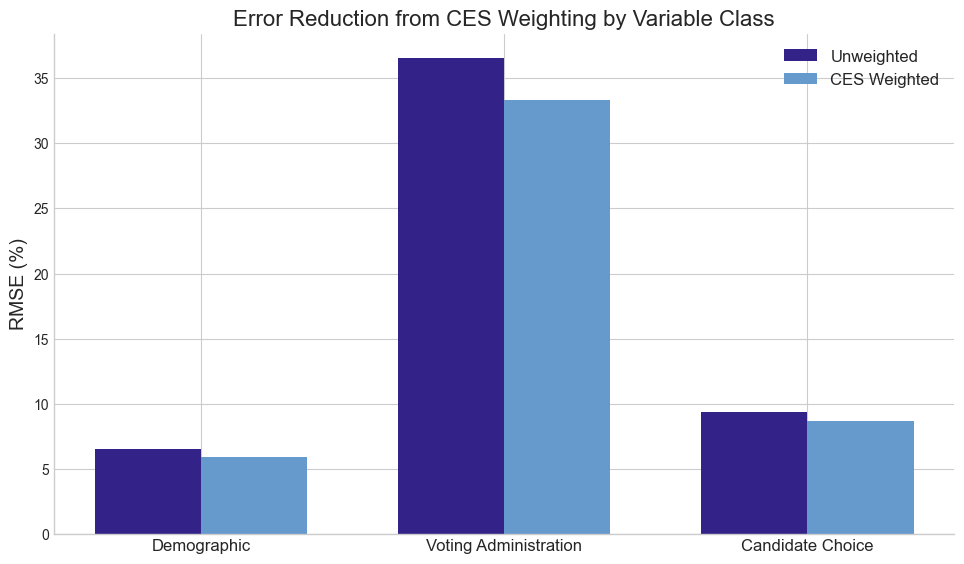


Error Reduction Summary:
Weighting_Method       CES-Unweighted  CES-Provided Weights  Reduction  \
Class                                                                    
Demographic                      6.52                  5.91       0.60   
Voting Administration           36.57                 33.33       3.24   
Candidate Choice                 9.37                  8.67       0.70   

Weighting_Method       Reduction_Pct  
Class                                 
Demographic                     9.25  
Voting Administration           8.86  
Candidate Choice                7.46  


In [15]:
# Calculate RMSE by weighting method and class
df_compare = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

rmse_by_method_class = df_compare.groupby(['Weighting_Method', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Pivot for comparison
method_pivot = rmse_by_method_class.pivot(index='Class', columns='Weighting_Method', values='RMSE')
method_pivot = method_pivot.reindex(class_order)

# Calculate reduction from unweighted to CES-weighted
method_pivot['Reduction'] = method_pivot['CES-Unweighted'] - method_pivot['CES-Provided Weights']
method_pivot['Reduction_Pct'] = (method_pivot['Reduction'] / method_pivot['CES-Unweighted']) * 100

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_order))
width = 0.35

bars1 = ax.bar(x - width/2, method_pivot['CES-Unweighted'], width, 
               label='Matching Only', color=WEIGHTING_COLORS['CES-Unweighted'])
bars2 = ax.bar(x + width/2, method_pivot['CES-Provided Weights'], width,
               label='Matching + Post-Stratification', color=WEIGHTING_COLORS['CES-Provided Weights'])

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Error Reduction from CES Weighting by Variable Class', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_order, fontsize=12)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

save_figure(fig, 'error_reduction_ces_weights_by_type.png')
plt.show()

print("\nError Reduction Summary:")
print(method_pivot[['CES-Unweighted', 'CES-Provided Weights', 'Reduction', 'Reduction_Pct']].round(2))

---
# ANESRake Full vs Restricted Comparison

Saved: output/anesrake_full_vs_restricted_comparison.png


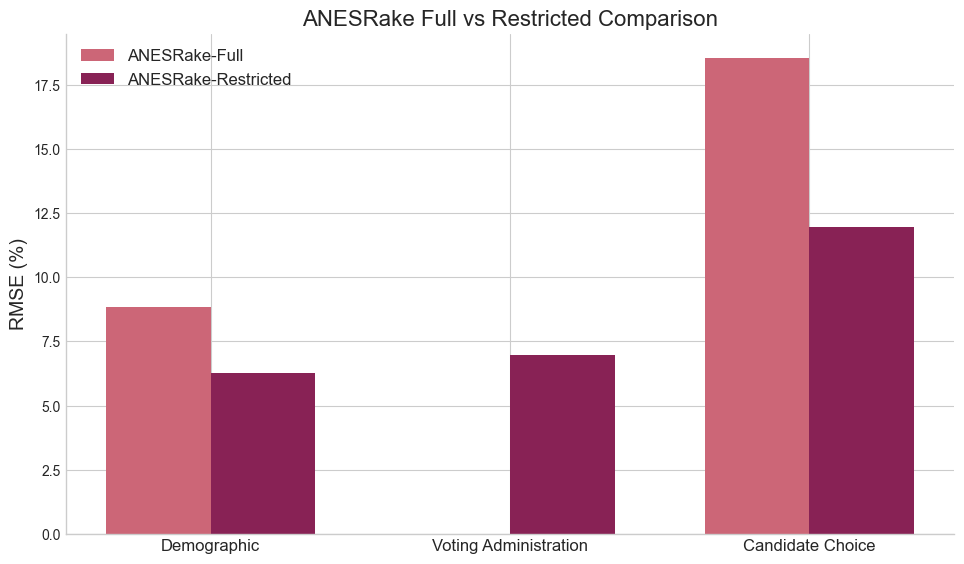


Saved: output/anesrake_full_vs_restricted_comparison.xlsx


In [16]:
# Compare ANESRake methods using appropriate validity schemes
df_anesrake_full = most_specific[
    (most_specific['Weighting_Method'] == 'ANESRake (Full)') &
    (most_specific['Validity_Scheme'] == 'ANESRake - Full')
]

df_anesrake_restricted = most_specific[
    (most_specific['Weighting_Method'] == 'ANESRake (Restricted)') &
    (most_specific['Validity_Scheme'] == 'ANESRake - Restricted')
]

rmse_full = df_anesrake_full.groupby('Class')['Error'].apply(
    lambda x: np.sqrt(np.mean(x ** 2))
).reindex(class_order)

rmse_restricted = df_anesrake_restricted.groupby('Class')['Error'].apply(
    lambda x: np.sqrt(np.mean(x ** 2))
).reindex(class_order)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_order))
width = 0.35

bars1 = ax.bar(x - width/2, rmse_full.values, width, 
               label='Matching + ANESRake Weights (Full)', color=WEIGHTING_COLORS['ANESRake-Full'])
bars2 = ax.bar(x + width/2, rmse_restricted.values, width,
               label='Matching + ANESRake Weights (Restricted)', color=WEIGHTING_COLORS['ANESRake-Restricted'])

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('ANESRake Full vs Restricted Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_order, fontsize=12)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

save_figure(fig, 'anesrake_full_vs_restricted_comparison.png')
plt.show()

# Save comparison data
comparison_df = pd.DataFrame({
    'Class': class_order,
    'Matching + ANESRake Weights (Full)': rmse_full.values,
    'Matching + ANESRake Weights (Restricted)': rmse_restricted.values
})
save_latex_table(df_to_latex_table(comparison_df, 'ANESRake Full vs Restricted Comparison', 'anesrake_full_vs_restricted_comparison', 'RMSE comparison between ANESRake Full and Restricted validity schemes.'), 'anesrake_full_vs_restricted_comparison.tex')
print("\nSaved: output/anesrake_full_vs_restricted_comparison.tex")

---
# Candidate vs Party Specificity

---
# RMSE by Office and Year Heatmap

---
# RMSE Excluding Voter Registration and Turnout

In [19]:
# ============================================================
# FIGURE 1A REPLICA: RMSE by Variable and Year
# (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)
# ============================================================

print("="*100)
print("FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)")
print("="*100)

# Filter for Matching + Post-Stratification, All validity, EXCLUDING the two high-error variables
df_excl = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (~most_specific['Variable'].isin(['Voter Registration', 'Voting Turnout']))
].copy()

print(f"\nTotal observations: {len(df_excl):,}")
print(f"Variables excluded: Voter Registration, Voting Turnout\n")

# Calculate RMSE by Year and Variable
rmse_by_var_year_excl = df_excl.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type for each cell
type_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

class_map_excl = rmse_by_var_year_excl.groupby('Variable')['Class'].first().to_dict()

rmse_pivot_excl = sort_variables(rmse_pivot_excl.reset_index()).set_index('Variable')
type_pivot_excl = sort_variables(type_pivot_excl.reset_index()).set_index('Variable')

years_excl = sorted([c for c in rmse_pivot_excl.columns if isinstance(c, (int, float))])

rmse_pivot_excl['Average'] = rmse_pivot_excl[years_excl].mean(axis=1)

avg_row_excl = rmse_pivot_excl.mean(axis=0)
avg_row_excl.name = 'Average'
rmse_pivot_with_avg_excl = pd.concat([rmse_pivot_excl, avg_row_excl.to_frame().T])

# Calculate class subtotals
class_values_excl = {cls: {year: [] for year in years_excl} for cls in class_order}
for var in rmse_pivot_excl.index:
    var_class = class_map_excl.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years_excl:
        val = rmse_pivot_excl.loc[var, year]
        if not pd.isna(val):
            class_values_excl[var_class][year].append(val)

class_subtotals_excl = {}
for cls in class_order:
    class_subtotals_excl[cls] = {}
    for year in years_excl:
        vals = class_values_excl[cls][year]
        class_subtotals_excl[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_excl[cls][y] for y in years_excl if not pd.isna(class_subtotals_excl[cls][y])]
    class_subtotals_excl[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Print formatted table
print("\n")
header = "{:<25}".format("Variable")
for year in years_excl:
    header += " {:>6}".format(str(int(year)))
header += " {:>12}".format("Yearly Mean")
print(header)
print("-" * len(header))

for cls in class_order:
    print(f"\n{cls}")
    
    for var in rmse_pivot_excl.index:
        var_class = class_map_excl.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row = "  {:<23}".format(var)
        for year in years_excl:
            val = rmse_pivot_excl.loc[var, year]
            if pd.isna(val):
                row += " {:>6}".format("-")
            else:
                var_type = type_pivot_excl.loc[var, year] if var in type_pivot_excl.index and year in type_pivot_excl.columns else None
                if var_type == 'Primary':
                    row += " {:>5}†".format(f"{val:.1f}")
                else:
                    row += " {:>6}".format(f"{val:.1f}")
        row_avg = rmse_pivot_with_avg_excl.loc[var, 'Average']
        if pd.isna(row_avg):
            row += " {:>12}".format("-")
        else:
            row += " {:>12}".format(f"{row_avg:.1f}")
        print(row)
    
    # Class average
    row = "  {:<23}".format(f"{cls} Avg.")
    for year in years_excl:
        val = class_subtotals_excl[cls][year]
        if pd.isna(val):
            row += " {:>6}".format("-")
        else:
            row += " {:>6}".format(f"{val:.1f}")
    row_avg = class_subtotals_excl[cls]['row_avg']
    if pd.isna(row_avg):
        row += " {:>12}".format("-")
    else:
        row += " {:>12}".format(f"{row_avg:.1f}")
    print(row)

# Yearly RMSE row
print("-" * len(header))
row = "{:<25}".format("Yearly RMSE")
yearly_rmse_values_excl = []
for year in years_excl:
    val = rmse_pivot_with_avg_excl.loc['Average', year]
    if pd.isna(val):
        row += " {:>6}".format("-")
    else:
        row += " {:>6}".format(f"{val:.1f}")
        yearly_rmse_values_excl.append(val)
annual_avg_excl = np.mean(yearly_rmse_values_excl) if yearly_rmse_values_excl else float('nan')
if pd.isna(annual_avg_excl):
    row += " {:>12}".format("-")
else:
    row += " {:>12}".format(f"{annual_avg_excl:.1f}")
print(row)

print("\n† indicates Primary variables (used in CES post-stratification weighting for that year)")

# Summary comparison
print("\n" + "="*80)
print("COMPARISON TO FIGURE 1 TABLE A (using mean-of-means approach)")
print("="*80)

# Calculate Figure 1 Table A approach for all variables
df_all = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
]
rmse_by_var_year_all = df_all.groupby(['Year', 'Variable']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')
rmse_pivot_all = rmse_by_var_year_all.pivot_table(index='Variable', columns='Year', values='RMSE')
years_all = sorted([c for c in rmse_pivot_all.columns if isinstance(c, (int, float))])
avg_row_all = rmse_pivot_all.mean(axis=0)
annual_avg_all = np.mean([avg_row_all[y] for y in years_all])

print(f"\nWith all variables (Figure 1 Table A bottom-right):")
print(f"  Overall RMSE: {annual_avg_all:.1f}%")

print(f"\nExcluding Voter Registration & Voting Turnout:")
print(f"  Overall RMSE: {annual_avg_excl:.1f}%")

print(f"\nReduction: {annual_avg_all - annual_avg_excl:.1f} percentage points")
print(f"({((annual_avg_all - annual_avg_excl) / annual_avg_all * 100):.0f}% lower error)")

FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)

Total observations: 9,528
Variables excluded: Voter Registration, Voting Turnout



Variable                    2006   2008   2010   2012   2014   2016   2018   2020   2022  Yearly Mean
-----------------------------------------------------------------------------------------------------

Demographic
  Age Group                  6.9   3.3†   4.8†   2.8†   2.8†   2.6†   4.0†   4.7†   5.2†          4.1
  Education                 13.0   3.3†   6.1†   3.5†   3.9†   5.7†   4.4†   4.5†   3.8†          5.3
  Sex                        5.2   6.8†   5.0†   1.5†   2.0†   1.3†   2.9†   2.5†   3.1†          3.4
  Hispanic Origin              -      -    7.6    8.1    7.5    7.6    7.8    7.0    2.7          6.9
  Employment Status          7.0   10.3   10.6   13.5   11.5   12.0   12.2   12.4   10.1         11.1
  Family Income              4.5    3.5    3.9    3.9    4.4    4.9    5.3    6.8    8.8          5.1
  Union Membership

---
# Summary: Generated Files

In [20]:
import os

print("="*80)
print("GENERATED FILES SUMMARY")
print("="*80)

output_files = sorted(os.listdir('output'))
print(f"\nTotal files in output/: {len(output_files)}")
print("\nFiles:")
for f in output_files:
    size = os.path.getsize(f'output/{f}')
    print(f"  - {f} ({size:,} bytes)")

GENERATED FILES SUMMARY

Total files in output/: 25

Files:
  - .DS_Store (6,148 bytes)
  - anesrake_full_vs_restricted_comparison.png (125,753 bytes)
  - anesrake_full_vs_restricted_comparison.xlsx (5,109 bytes)
  - candidate_vs_party_specificity.png (74,612 bytes)
  - candidate_vs_party_specificity.xlsx (5,003 bytes)
  - error_distribution_by_class.png (145,213 bytes)
  - error_reduction_ces_weights_by_type.png (125,009 bytes)
  - error_trends_over_time.png (215,635 bytes)
  - primary_secondary_delta.tex (891 bytes)
  - primary_vs_secondary_by_year_stacked.png (249,722 bytes)
  - rmse_by_class_histogram.png (107,351 bytes)
  - rmse_by_office_federal_state.png (275,408 bytes)
  - rmse_by_office_salience.png (277,444 bytes)
  - rmse_by_office_salience_party.png (290,454 bytes)
  - rmse_by_office_year.xlsx (6,059 bytes)
  - rmse_by_office_year_heatmap.png (274,658 bytes)
  - rmse_ces_weighted_all.tex (4,917 bytes)
  - rmse_ces_weighted_by_type.tex (7,370 bytes)
  - rmse_party_vs_candida

---
# Congressional District Size and U.S. House Accuracy

Analysis of how the number of CES respondents per congressional district affects U.S. House vote accuracy.

Total unique districts: 2839

Districts by bucket: {'0-50': np.int64(319), '50-100': np.int64(1682), '100-200': np.int64(835), '200-400': np.int64(3), '400-800': np.int64(0), '800+': np.int64(0)}

Average Absolute Error by bucket:
  0-50: 10.2% (n=319)
  50-100: 7.6% (n=1682)
  100-200: 5.9% (n=835)
  200-400: 3.9% (n=3)


Saved: output/us_house_error_by_cd_size.png


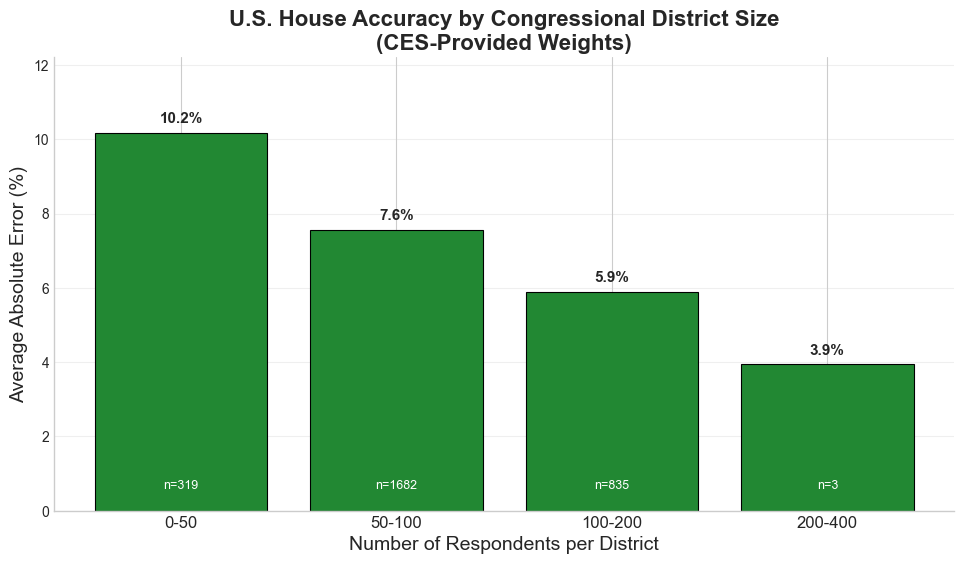

Saved: output/us_house_cd_size_distribution.png

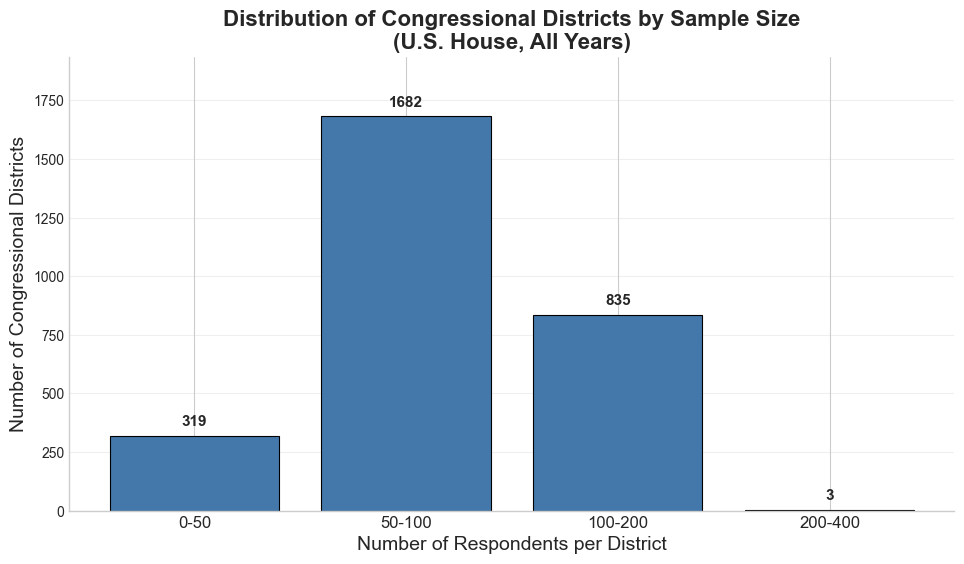


RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS

Year     All Districts      >100 respondents  
---------------------------------------------
2006            4.9%               4.3%
2008            8.6%               6.0%
2010           10.1%               6.2%
2012            9.3%               6.8%
2014            8.7%               6.2%
2016            9.2%               7.2%
2018            9.1%               5.6%
2020            7.7%               6.4%
2022            9.7%               7.3%
---------------------------------------------
Average         8.6%               6.2%

Districts: 2839 total, 809 with >100 respondents (28.5%)

Sentence: "If we had only measured error in CDs with >100 respondents,
the annual average RMSE for U.S. House would have gone from 8.6% to 6.2%."


In [21]:
# =============================================================================
# CONGRESSIONAL DISTRICT SIZE AND U.S. HOUSE ACCURACY
# =============================================================================

# Filter for U.S. House, Matching + Post-Strat., Validity_Scheme='All'
df_house = metrics_base_full[
    (metrics_base_full['Variable'] == 'U.S. House') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All')
].copy()

# Create absolute error
df_house['Abs_Error'] = df_house['Error'].abs()

# Define buckets
def get_bucket(n):
    if n < 50:
        return '0-50'
    elif n < 100:
        return '50-100'
    elif n < 200:
        return '100-200'
    elif n < 400:
        return '200-400'
    elif n < 800:
        return '400-800'
    else:
        return '800+'

df_house['Respondent_Bucket'] = df_house['n_respondents'].apply(get_bucket)
bucket_order = ['0-50', '50-100', '100-200', '200-400', '400-800', '800+']

# Get unique district-level data
districts_df = df_house.groupby(['Year', 'State', 'District']).agg({
    'n_respondents': 'first',
    'Abs_Error': 'mean'
}).reset_index()
districts_df['Respondent_Bucket'] = districts_df['n_respondents'].apply(get_bucket)

# Calculate stats by bucket
district_counts = districts_df['Respondent_Bucket'].value_counts().reindex(bucket_order, fill_value=0)
avg_error_by_bucket = districts_df.groupby('Respondent_Bucket')['Abs_Error'].mean().reindex(bucket_order)

print(f"Total unique districts: {len(districts_df)}")
print(f"\nDistricts by bucket: {dict(district_counts)}")
print(f"\nAverage Absolute Error by bucket:")
for b in bucket_order:
    if district_counts[b] > 0:
        print(f"  {b}: {avg_error_by_bucket[b]:.1f}% (n={district_counts[b]})")

# ============================================================
# PLOT 1: Average Absolute Error by Respondent Bucket
# ============================================================
fig1, ax1 = plt.subplots(figsize=(10, 6))

valid_buckets = [b for b in bucket_order if district_counts[b] > 0]
x_pos = np.arange(len(valid_buckets))
values = [avg_error_by_bucket[b] for b in valid_buckets]
counts = [district_counts[b] for b in valid_buckets]

bars = ax1.bar(x_pos, values, color=CLASS_COLORS['Candidate Choice'], edgecolor='black', linewidth=0.8)

for i, (bar, val, n) in enumerate(zip(bars, values, counts)):
    ax1.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax1.annotate(f'n={n}', xy=(bar.get_x() + bar.get_width()/2, 0.5),
                ha='center', va='bottom', fontsize=9, color='white')

ax1.set_xlabel('Number of Respondents per District', fontsize=14)
ax1.set_ylabel('Average Absolute Error (%)', fontsize=14)
ax1.set_title('U.S. House Accuracy by Congressional District Size\n(Matching + Post-Stratification)', fontsize=16, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(valid_buckets, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(0, max(values) * 1.2)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig1, 'us_house_error_by_cd_size.png')
plt.show()

# ============================================================
# PLOT 2: Distribution of Districts by Respondent Bucket
# ============================================================
fig2, ax2 = plt.subplots(figsize=(10, 6))

bars2 = ax2.bar(x_pos, counts, color=CLASS_COLORS['Demographic'], edgecolor='black', linewidth=0.8)

for bar, n in zip(bars2, counts):
    ax2.annotate(f'{n}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('Number of Respondents per District', fontsize=14)
ax2.set_ylabel('Number of Congressional Districts', fontsize=14)
ax2.set_title('Distribution of Congressional Districts by Sample Size\n(U.S. House, All Years)', fontsize=16, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(valid_buckets, fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, max(counts) * 1.15)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig2, 'us_house_cd_size_distribution.png')
plt.show()

# ============================================================
# RMSE Comparison: All Districts vs Large Districts
# ============================================================
print("\n" + "="*70)
print("RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS")
print("="*70)

rmse_all_by_year = df_house.groupby('Year')['Error'].apply(calculate_rmse)
df_100plus = df_house[df_house['n_respondents'] > 100]
rmse_100plus_by_year = df_100plus.groupby('Year')['Error'].apply(calculate_rmse)

print(f"\n{'Year':<8} {'All Districts':<18} {'>100 respondents':<18}")
print("-"*45)
for year in sorted(df_house['Year'].unique()):
    all_val = rmse_all_by_year.get(year, np.nan)
    plus100_val = rmse_100plus_by_year.get(year, np.nan)
    print(f"{year:<8} {all_val:>10.1f}%        {plus100_val:>10.1f}%")

avg_all = rmse_all_by_year.mean()
avg_100plus = rmse_100plus_by_year.mean()
print("-"*45)
print(f"{'Average':<8} {avg_all:>10.1f}%        {avg_100plus:>10.1f}%")

n_all = df_house.groupby(['Year', 'State', 'District']).ngroups
n_100plus = df_100plus.groupby(['Year', 'State', 'District']).ngroups
print(f"\nDistricts: {n_all} total, {n_100plus} with >100 respondents ({100*n_100plus/n_all:.1f}%)")
print(f"\nSentence: \"If we had only measured error in CDs with >100 respondents,")
print(f"the annual average RMSE for U.S. House would have gone from {avg_all:.1f}% to {avg_100plus:.1f}%.\"")


---
# Candidate Choice Accuracy by Office Grouping

Two perspectives on office-level accuracy differences:
1. Federal vs State-Level (Federal, State Executive, State Legislative)
2. Race Salience (High/Medium/Low visibility)

RMSE by Office:
  President: 2.72%
  Governor: 4.45%
  U.S. Senate: 5.32%
  State Representative: 7.69%
  Secretary of State: 8.90%
  State Senator: 8.93%
  U.S. House: 9.43%
  Attorney General: 10.12%


Saved: output/rmse_by_office_federal_state.png


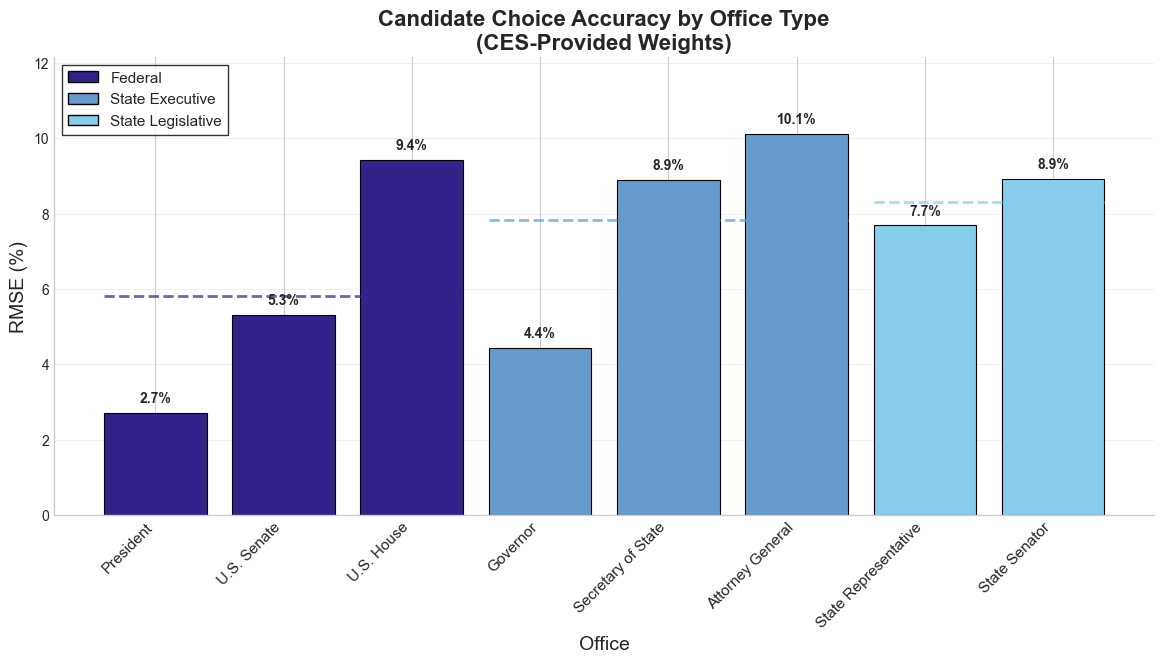

Saved: output/rmse_by_office_salience.png


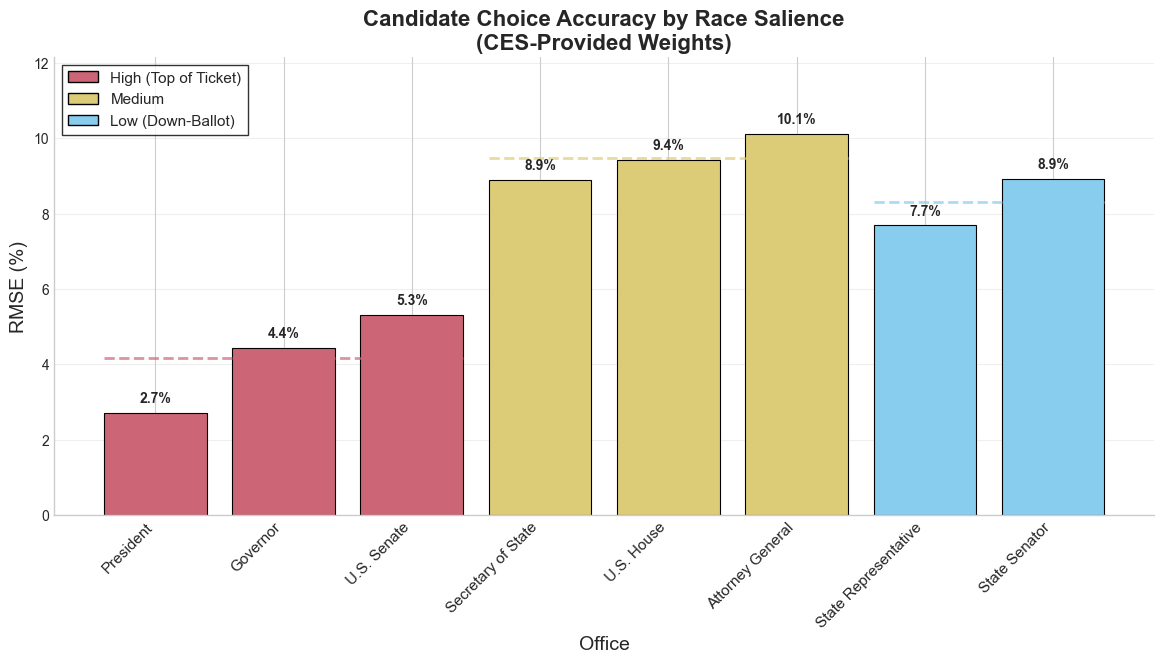


SUMMARY: RMSE by Grouping

Federal vs State-Level:
  Federal: 5.8%
  State Executive: 7.8%
  State Legislative: 8.3%

Race Salience:
  High (Top of Ticket): 4.2%
  Medium: 9.5%
  Low (Down-Ballot): 8.3%


In [22]:
# =============================================================================
# CANDIDATE CHOICE ACCURACY BY OFFICE GROUPING
# =============================================================================

# Filter for Candidate Choice, Matching + Post-Strat., Validity_Scheme='All'
df_candidate = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by office
rmse_by_office = df_candidate.groupby('Variable')['Error'].apply(calculate_rmse).sort_values()

print("RMSE by Office:")
for office, rmse in rmse_by_office.items():
    print(f"  {office}: {rmse:.2f}%")

# Define groupings
FEDERAL_STATE_GROUPS = {
    'President': 'Federal',
    'U.S. Senate': 'Federal',
    'U.S. House': 'Federal',
    'Governor': 'State Executive',
    'Attorney General': 'State Executive',
    'Secretary of State': 'State Executive',
    'State Senator': 'State Legislative',
    'State Representative': 'State Legislative'
}

SALIENCE_GROUPS = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

# Colors
GROUP_COLORS_OFFICE = {
    'Federal': '#332288',
    'State Executive': '#6699CC',
    'State Legislative': '#88CCEE'
}

SALIENCE_COLORS = {
    'High (Top of Ticket)': '#CC6677',
    'Medium': '#DDCC77',
    'Low (Down-Ballot)': '#88CCEE'
}

# ============================================================
# PLOT 1: Federal vs State-Level Grouping
# ============================================================
fig1, ax1 = plt.subplots(figsize=(12, 7))

group_order = ['Federal', 'State Executive', 'State Legislative']
offices_ordered = []
for group in group_order:
    group_offices = [o for o, g in FEDERAL_STATE_GROUPS.items() if g == group]
    group_offices_sorted = sorted(group_offices, key=lambda x: rmse_by_office.get(x, 0))
    offices_ordered.extend(group_offices_sorted)

x_pos = np.arange(len(offices_ordered))
values = [rmse_by_office.get(o, 0) for o in offices_ordered]
colors = [GROUP_COLORS_OFFICE[FEDERAL_STATE_GROUPS[o]] for o in offices_ordered]

bars = ax1.bar(x_pos, values, color=colors, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, values):
    ax1.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add group averages
for group in group_order:
    group_offices = [o for o, g in FEDERAL_STATE_GROUPS.items() if g == group]
    group_rmse = np.mean([rmse_by_office.get(o, 0) for o in group_offices if o in rmse_by_office])
    indices = [i for i, o in enumerate(offices_ordered) if FEDERAL_STATE_GROUPS[o] == group]
    if indices:
        ax1.hlines(group_rmse, min(indices) - 0.4, max(indices) + 0.4, 
                   colors=GROUP_COLORS_OFFICE[group], linestyles='--', linewidth=2, alpha=0.7)

ax1.set_xlabel('Office', fontsize=14)
ax1.set_ylabel('RMSE (%)', fontsize=14)
ax1.set_title('Candidate Choice Accuracy by Office Type\n(Matching + Post-Stratification)', fontsize=16, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(offices_ordered, rotation=45, ha='right', fontsize=11)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(0, max(values) * 1.2)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=GROUP_COLORS_OFFICE[g], edgecolor='black', label=g) for g in group_order]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True, fancybox=False, edgecolor='black')

save_figure(fig1, 'rmse_by_office_federal_state.png')
plt.show()

# ============================================================
# PLOT 2: Race Salience/Visibility
# ============================================================
fig2, ax2 = plt.subplots(figsize=(12, 7))

salience_order = ['High (Top of Ticket)', 'Medium', 'Low (Down-Ballot)']
offices_by_salience = []
for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS.items() if s == salience]
    salience_offices_sorted = sorted(salience_offices, key=lambda x: rmse_by_office.get(x, 0))
    offices_by_salience.extend(salience_offices_sorted)

x_pos2 = np.arange(len(offices_by_salience))
values2 = [rmse_by_office.get(o, 0) for o in offices_by_salience]
colors2 = [SALIENCE_COLORS[SALIENCE_GROUPS[o]] for o in offices_by_salience]

bars2 = ax2.bar(x_pos2, values2, color=colors2, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars2, values2):
    ax2.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS.items() if s == salience]
    salience_rmse = np.mean([rmse_by_office.get(o, 0) for o in salience_offices if o in rmse_by_office])
    indices = [i for i, o in enumerate(offices_by_salience) if SALIENCE_GROUPS[o] == salience]
    if indices:
        ax2.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                   colors=SALIENCE_COLORS[salience], linestyles='--', linewidth=2, alpha=0.7)

ax2.set_xlabel('Office', fontsize=14)
ax2.set_ylabel('RMSE (%)', fontsize=14)
ax2.set_title('Candidate Choice Accuracy by Race Salience\n(Matching + Post-Stratification)', fontsize=16, fontweight='bold')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(offices_by_salience, rotation=45, ha='right', fontsize=11)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, max(values2) * 1.2)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

legend_elements2 = [Patch(facecolor=SALIENCE_COLORS[s], edgecolor='black', label=s) for s in salience_order]
ax2.legend(handles=legend_elements2, loc='upper left', fontsize=11, frameon=True, fancybox=False, edgecolor='black')

save_figure(fig2, 'rmse_by_office_salience.png')
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: RMSE by Grouping")
print("="*60)
print("\nFederal vs State-Level:")
for group in group_order:
    group_offices = [o for o, g in FEDERAL_STATE_GROUPS.items() if g == group]
    group_rmse = np.mean([rmse_by_office.get(o, 0) for o in group_offices if o in rmse_by_office])
    print(f"  {group}: {group_rmse:.1f}%")

print("\nRace Salience:")
for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS.items() if s == salience]
    salience_rmse = np.mean([rmse_by_office.get(o, 0) for o in salience_offices if o in rmse_by_office])
    print(f"  {salience}: {salience_rmse:.1f}%")

In [ ]:
# =============================================================================
# CANDIDATE CHOICE ACCURACY BY OFFICE GROUPING - SECONDARY ONLY
# Only includes races where the variable was Secondary for that year
# =============================================================================

# Filter for Candidate Choice, Matching + Post-Strat., Validity_Scheme='All', AND Secondary only
df_candidate_sec = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable_Type'] == 'Secondary')
].copy()

print(f"Secondary-only observations: {len(df_candidate_sec)}")
print(f"Years with Secondary data per office:")
for office in df_candidate_sec['Variable'].unique():
    years = sorted(df_candidate_sec[df_candidate_sec['Variable'] == office]['Year'].unique())
    print(f"  {office}: {years}")

# Calculate RMSE by office
rmse_by_office_sec = df_candidate_sec.groupby('Variable')['Error'].apply(calculate_rmse).sort_values()

print("\nRMSE by Office (Secondary Only):")
for office, rmse in rmse_by_office_sec.items():
    print(f"  {office}: {rmse:.2f}%")

# Define groupings
FEDERAL_STATE_GROUPS = {
    'President': 'Federal',
    'U.S. Senate': 'Federal',
    'U.S. House': 'Federal',
    'Governor': 'State Executive',
    'Attorney General': 'State Executive',
    'Secretary of State': 'State Executive',
    'State Senator': 'State Legislative',
    'State Representative': 'State Legislative'
}

SALIENCE_GROUPS = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

# Colors
GROUP_COLORS_OFFICE = {
    'Federal': '#332288',
    'State Executive': '#6699CC',
    'State Legislative': '#88CCEE'
}

SALIENCE_COLORS = {
    'High (Top of Ticket)': '#CC6677',
    'Medium': '#DDCC77',
    'Low (Down-Ballot)': '#88CCEE'
}

# ============================================================
# PLOT 1: Federal vs State-Level Grouping (Secondary Only)
# ============================================================
fig1, ax1 = plt.subplots(figsize=(12, 7))

group_order = ['Federal', 'State Executive', 'State Legislative']
offices_by_group = []
for group in group_order:
    group_offices = [o for o, g in FEDERAL_STATE_GROUPS.items() if g == group and o in rmse_by_office_sec]
    offices_by_group.extend(sorted(group_offices, key=lambda x: rmse_by_office_sec.get(x, 0)))

x_pos = np.arange(len(offices_by_group))
values = [rmse_by_office_sec.get(o, 0) for o in offices_by_group]
colors = [GROUP_COLORS_OFFICE[FEDERAL_STATE_GROUPS[o]] for o in offices_by_group]

bars = ax1.bar(x_pos, values, color=colors, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, values):
    ax1.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

for group in group_order:
    group_offices = [o for o, g in FEDERAL_STATE_GROUPS.items() if g == group and o in rmse_by_office_sec]
    if group_offices:
        group_rmse = np.mean([rmse_by_office_sec.get(o, 0) for o in group_offices])
        indices = [i for i, o in enumerate(offices_by_group) if FEDERAL_STATE_GROUPS[o] == group]
        if indices:
            ax1.hlines(group_rmse, min(indices) - 0.4, max(indices) + 0.4,
                      colors=GROUP_COLORS_OFFICE[group], linestyles='--', linewidth=2, alpha=0.7)

ax1.set_xlabel('Office', fontsize=14)
ax1.set_ylabel('RMSE (%)', fontsize=14)
ax1.set_title('Candidate Choice Accuracy by Government Level\n(Secondary Variables Only, Matching + Post-Strat.)', fontsize=16, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(offices_by_group, rotation=45, ha='right', fontsize=11)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c, edgecolor='black', label=g) 
                   for g, c in GROUP_COLORS_OFFICE.items()]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=11)

plt.tight_layout()
save_figure(fig1, 'rmse_by_office_federal_state_secondary.png')
plt.show()

# ============================================================
# PLOT 2: Race Salience Grouping (Secondary Only)
# ============================================================
fig2, ax2 = plt.subplots(figsize=(12, 7))

salience_order = ['High (Top of Ticket)', 'Medium', 'Low (Down-Ballot)']
offices_by_salience = []
for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS.items() if s == salience and o in rmse_by_office_sec]
    offices_by_salience.extend(sorted(salience_offices, key=lambda x: rmse_by_office_sec.get(x, 0)))

x_pos = np.arange(len(offices_by_salience))
values = [rmse_by_office_sec.get(o, 0) for o in offices_by_salience]
colors = [SALIENCE_COLORS[SALIENCE_GROUPS[o]] for o in offices_by_salience]

bars = ax2.bar(x_pos, values, color=colors, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, values):
    ax2.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS.items() if s == salience and o in rmse_by_office_sec]
    if salience_offices:
        salience_rmse = np.mean([rmse_by_office_sec.get(o, 0) for o in salience_offices])
        indices = [i for i, o in enumerate(offices_by_salience) if SALIENCE_GROUPS[o] == salience]
        if indices:
            ax2.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                      colors=SALIENCE_COLORS[salience], linestyles='--', linewidth=2, alpha=0.7)

ax2.set_xlabel('Office', fontsize=14)
ax2.set_ylabel('RMSE (%)', fontsize=14)
ax2.set_title('Candidate Choice Accuracy by Race Salience\n(Secondary Variables Only, Matching + Post-Strat.)', fontsize=16, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(offices_by_salience, rotation=45, ha='right', fontsize=11)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c, edgecolor='black', label=s) 
                   for s, c in SALIENCE_COLORS.items()]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=11)

plt.tight_layout()
save_figure(fig2, 'rmse_by_office_salience_secondary.png')
plt.show()



---
# Race Salience: Party-Level Specificity

Same salience analysis but using Party-level specificity for all offices (includes State Senator and State Representative).

RMSE by Office (Party-level specificity):
  President: 2.39%
  Governor: 4.44%
  U.S. House: 4.59%
  U.S. Senate: 5.46%
  State Representative: 7.69%
  Secretary of State: 8.90%
  State Senator: 8.93%
  Attorney General: 10.39%


Saved: output/rmse_by_office_salience_party.png


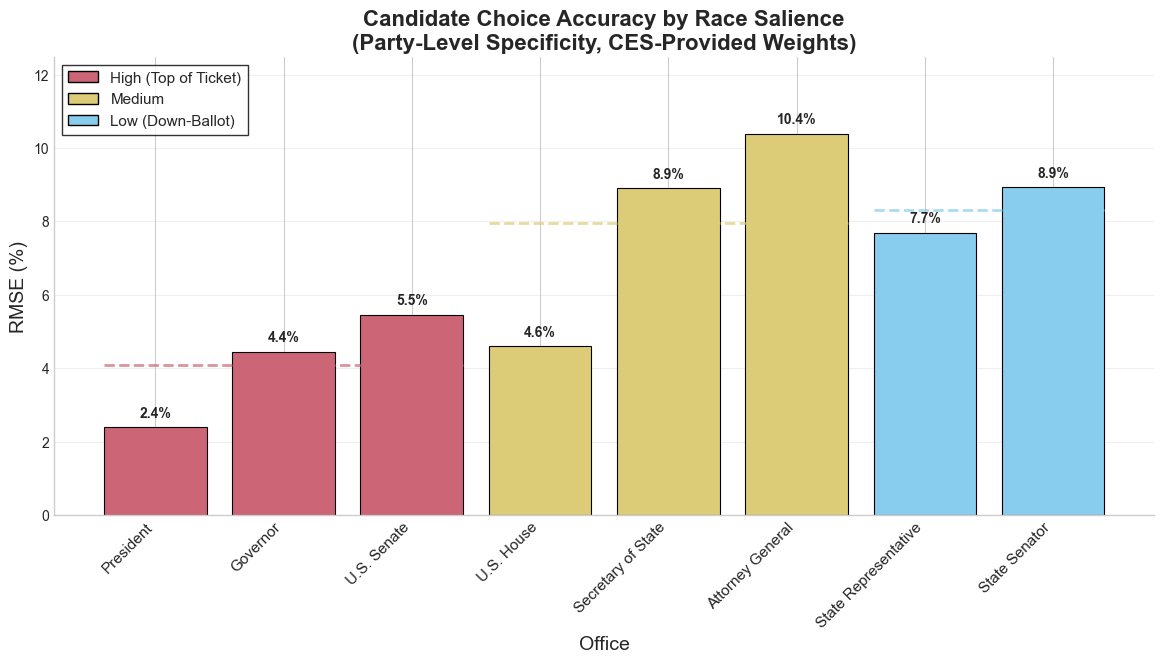


Salience Group Averages (Party-level):
  High (Top of Ticket): 4.1%
  Medium: 8.0%
  Low (Down-Ballot): 8.3%


In [23]:
# =============================================================================
# RACE SALIENCE: PARTY-LEVEL SPECIFICITY
# =============================================================================

# Filter for Party specificity, Matching + Post-Strat., Validity_Scheme='All'
df_party = metrics_base_full[
    (metrics_base_full['Class'] == 'Candidate Choice') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All') &
    (metrics_base_full['Specificity'] == 'Party')
].copy()

rmse_by_office_party = df_party.groupby('Variable')['Error'].apply(calculate_rmse).sort_values()

print("RMSE by Office (Party-level specificity):")
for office, rmse in rmse_by_office_party.items():
    print(f"  {office}: {rmse:.2f}%")

SALIENCE_GROUPS_ALL = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

fig, ax = plt.subplots(figsize=(12, 7))

salience_order = ['High (Top of Ticket)', 'Medium', 'Low (Down-Ballot)']
offices_by_salience = []
for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS_ALL.items() if s == salience and o in rmse_by_office_party]
    offices_by_salience.extend(sorted(salience_offices, key=lambda x: rmse_by_office_party.get(x, 0)))

x_pos = np.arange(len(offices_by_salience))
values = [rmse_by_office_party.get(o, 0) for o in offices_by_salience]
colors = [SALIENCE_COLORS[SALIENCE_GROUPS_ALL[o]] for o in offices_by_salience]

bars = ax.bar(x_pos, values, color=colors, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, values):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS_ALL.items() if s == salience and o in rmse_by_office_party]
    if salience_offices:
        salience_rmse = np.mean([rmse_by_office_party.get(o, 0) for o in salience_offices])
        indices = [i for i, o in enumerate(offices_by_salience) if SALIENCE_GROUPS_ALL[o] == salience]
        if indices:
            ax.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                      colors=SALIENCE_COLORS[salience], linestyles='--', linewidth=2, alpha=0.7)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Candidate Choice Accuracy by Race Salience\n(Party-Level Specificity, Matching + Post-Strat.)', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(offices_by_salience, rotation=45, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(axis='y', linestyle='-', alpha=0.3)

legend_elements = [Patch(facecolor=SALIENCE_COLORS[s], edgecolor='black', label=s) for s in salience_order]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True, fancybox=False, edgecolor='black')

save_figure(fig, 'rmse_by_office_salience_party.png')
plt.show()

print("\nSalience Group Averages (Party-level):")
for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS_ALL.items() if s == salience and o in rmse_by_office_party]
    if salience_offices:
        print(f"  {salience}: {np.mean([rmse_by_office_party.get(o, 0) for o in salience_offices]):.1f}%")

In [ ]:
# =============================================================================
# RACE SALIENCE: PARTY-LEVEL SPECIFICITY - SECONDARY ONLY
# =============================================================================

# Filter for Party specificity, Matching + Post-Strat., Validity_Scheme='All', Secondary only
df_party_sec = metrics_base_full[
    (metrics_base_full['Class'] == 'Candidate Choice') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All') &
    (metrics_base_full['Specificity'] == 'Party') &
    (metrics_base_full['Variable_Type'] == 'Secondary')
].copy()

print(f"Secondary-only observations (Party specificity): {len(df_party_sec)}")

rmse_by_office_party_sec = df_party_sec.groupby('Variable')['Error'].apply(calculate_rmse).sort_values()

print("\nRMSE by Office (Party-level specificity, Secondary Only):")
for office, rmse in rmse_by_office_party_sec.items():
    print(f"  {office}: {rmse:.2f}%")

SALIENCE_GROUPS_ALL = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

fig, ax = plt.subplots(figsize=(12, 7))

salience_order = ['High (Top of Ticket)', 'Medium', 'Low (Down-Ballot)']
offices_by_salience = []
for salience in salience_order:
    salience_offices = [o for o, s in SALIENCE_GROUPS_ALL.items() if s == salience and o in rmse_by_office_party_sec]
    offices_by_salience.extend(sorted(salience_offices, key=lambda x: rmse_by_office_party_sec.get(x, 0)))

if len(offices_by_salience) == 0:
    print("No Secondary-only data available for Party specificity")
else:
    x_pos = np.arange(len(offices_by_salience))
    values = [rmse_by_office_party_sec.get(o, 0) for o in offices_by_salience]
    colors = [SALIENCE_COLORS[SALIENCE_GROUPS_ALL[o]] for o in offices_by_salience]

    bars = ax.bar(x_pos, values, color=colors, edgecolor='black', linewidth=0.8)

    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

    for salience in salience_order:
        salience_offices = [o for o, s in SALIENCE_GROUPS_ALL.items() if s == salience and o in rmse_by_office_party_sec]
        if salience_offices:
            salience_rmse = np.mean([rmse_by_office_party_sec.get(o, 0) for o in salience_offices])
            indices = [i for i, o in enumerate(offices_by_salience) if SALIENCE_GROUPS_ALL[o] == salience]
            if indices:
                ax.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                          colors=SALIENCE_COLORS[salience], linestyles='--', linewidth=2, alpha=0.7)

    ax.set_xlabel('Office', fontsize=14)
    ax.set_ylabel('RMSE (%)', fontsize=14)
    ax.set_title('Candidate Choice Accuracy by Race Salience\n(Party-Level Specificity, Secondary Only, Matching + Post-Strat.)', fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(offices_by_salience, rotation=45, ha='right', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c, edgecolor='black', label=s) 
                       for s, c in SALIENCE_COLORS.items()]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11)

    plt.tight_layout()
    save_figure(fig, 'rmse_by_office_salience_party_secondary.png')
    plt.show()



---
# Party vs Candidate Specificity Comparison

For offices that have both Party and Candidate level data, compare RMSE using only overlapping years.

RMSE COMPARISON: PARTY vs CANDIDATE SPECIFICITY
(Using only years where BOTH are available)

Office               Years        Party      Candidate    Diff      
----------------------------------------------------------------------
U.S. House           2008-2022       4.6%         9.5%      +4.9%
Governor             2010-2022       4.3%         4.3%      +0.0%
President            2012-2020       2.4%         2.4%      +0.0%
Secretary of State   2018-2022       5.2%         5.2%      +0.0%
U.S. Senate          2008-2022       5.3%         5.1%      -0.2%
Attorney General     2018-2022       7.1%         6.0%      -1.1%


Saved: output/rmse_party_vs_candidate_comparison.png


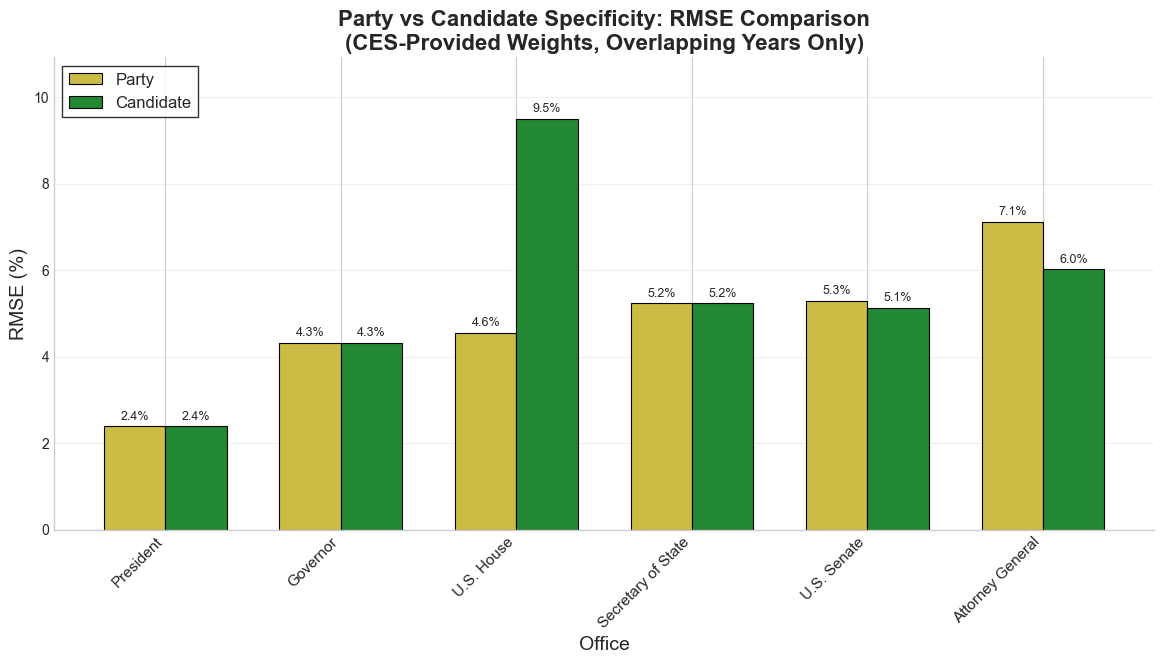


Saved: output/rmse_party_vs_candidate_comparison.xlsx


In [24]:
# =============================================================================
# PARTY VS CANDIDATE SPECIFICITY COMPARISON
# =============================================================================

df_cc = metrics_base_full[
    (metrics_base_full['Class'] == 'Candidate Choice') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All')
].copy()

both_offices = ['President', 'U.S. Senate', 'U.S. House', 'Governor', 'Attorney General', 'Secretary of State']

print("="*80)
print("RMSE COMPARISON: PARTY vs CANDIDATE SPECIFICITY")
print("(Using only years where BOTH are available)")
print("="*80)

results = []
for office in both_offices:
    party_years = set(df_cc[(df_cc['Variable'] == office) & (df_cc['Specificity'] == 'Party')]['Year'].unique())
    cand_years = set(df_cc[(df_cc['Variable'] == office) & (df_cc['Specificity'] == 'Candidate')]['Year'].unique())
    overlap_years = party_years & cand_years
    
    if not overlap_years:
        continue
    
    df_office = df_cc[(df_cc['Variable'] == office) & (df_cc['Year'].isin(overlap_years))]
    rmse_party = calculate_rmse(df_office[df_office['Specificity'] == 'Party']['Error'])
    rmse_cand = calculate_rmse(df_office[df_office['Specificity'] == 'Candidate']['Error'])
    
    results.append({
        'Office': office,
        'Years': f"{min(overlap_years)}-{max(overlap_years)}",
        'RMSE_Party': rmse_party,
        'RMSE_Candidate': rmse_cand,
        'Difference': rmse_cand - rmse_party
    })

results_df = pd.DataFrame(results).sort_values('Difference', ascending=False)

print(f"\n{'Office':<20} {'Years':<12} {'Party':<10} {'Candidate':<12} {'Diff':<10}")
print("-"*70)
for _, row in results_df.iterrows():
    print(f"{row['Office']:<20} {row['Years']:<12} {row['RMSE_Party']:>6.1f}%    {row['RMSE_Candidate']:>8.1f}%    {row['Difference']:>+6.1f}%")

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 7))

offices_sorted = results_df.sort_values('RMSE_Party')['Office'].tolist()
x = np.arange(len(offices_sorted))
width = 0.35

party_vals = [results_df[results_df['Office'] == o]['RMSE_Party'].values[0] for o in offices_sorted]
cand_vals = [results_df[results_df['Office'] == o]['RMSE_Candidate'].values[0] for o in offices_sorted]

bars1 = ax.bar(x - width/2, party_vals, width, label='Party', color=SPECIFICITY_COLORS['Party'], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, cand_vals, width, label='Candidate', color=SPECIFICITY_COLORS['Candidate'], edgecolor='black', linewidth=0.8)

for bar in bars1:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Party vs Candidate Specificity: RMSE Comparison\n(Matching + Post-Strat., Overlapping Years Only)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(offices_sorted, rotation=45, ha='right', fontsize=11)
ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=False, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(max(party_vals), max(cand_vals)) * 1.15)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_party_vs_candidate_comparison.png')
plt.show()

save_latex_table(df_to_latex_table(
    results_df,
    'Party vs Candidate RMSE Comparison',
    'rmse_party_vs_candidate_comparison',
    'RMSE comparison between party-level and candidate-level specificity across offices.'
), 'rmse_party_vs_candidate_comparison.tex')
print("\nSaved: output/rmse_party_vs_candidate_comparison.tex")

In [ ]:
# =============================================================================
# RMSE BY RACE COMPETITIVENESS (HISTOGRAM)
# =============================================================================

# Filter: Candidate Choice, All validity, CES Weights
data_competitiveness = most_specific[
    (most_specific['Class'] == 'Candidate Choice') & 
    (most_specific['Validity_Scheme'] == 'All') & 
    (most_specific['Weighting_Method'] == 'CES-Provided Weights')
].copy()

# Calculate absolute error
data_competitiveness['Abs_Error'] = data_competitiveness['Error'].abs()

# Define bands with darker colors (symmetric)
bands = [
    (0, 20, '0-20%', '#d9867d'),      # Darker red-pink
    (20, 40, '20-40%', '#e8b89d'),    # Darker tan
    (40, 60, '40-60%', '#d4e8b8'),    # Darker soft green (most competitive)
    (60, 80, '60-80%', '#e8b89d'),    # Darker tan
    (80, 90, '80-90%', '#e8b89d'),    # Darker tan
    (90, 100, '90-100%', '#d9867d'),  # Darker red-pink
]

# Calculate RMSE for each band
band_labels = []
rmse_values = []
colors = []
sample_sizes = []

for start, end, label, color in bands:
    band_data = data_competitiveness[(data_competitiveness['Benchmark'] >= start) & 
                                      (data_competitiveness['Benchmark'] < end)]
    if len(band_data) > 0:
        rmse = np.sqrt(np.mean(band_data['Abs_Error'] ** 2))
        band_labels.append(label)
        rmse_values.append(rmse)
        colors.append(color)
        sample_sizes.append(len(band_data))

# Create histogram
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars
bars = ax.bar(range(len(band_labels)), rmse_values, color=colors, 
              edgecolor='#555555', linewidth=1.5, alpha=0.92)

# Add value labels on bars (positioned at 60% height)
for i, (bar, rmse, n) in enumerate(zip(bars, rmse_values, sample_sizes)):
    height = bar.get_height()
    y_pos = height * 0.6
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{rmse:.1f}\n(n={n:,})',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor='none', alpha=0.85))

# Styling
ax.set_xlabel('Benchmark Vote Share Range', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('RMSE (%)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('RMSE by Race Competitiveness (Matching + Post-Stratification Estimates)', 
            fontsize=15, fontweight='bold', pad=15)

ax.set_xticks(range(len(band_labels)))
ax.set_xticklabels(band_labels, fontsize=11)
ax.set_ylim(0, max(rmse_values) * 1.1)
ax.set_yticks(np.arange(0, max(rmse_values) * 1.1, 5))
ax.set_yticklabels(np.arange(0, max(rmse_values) * 1.1, 5), fontsize=10)

ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add competitiveness label
ax.text(2.5, max(rmse_values) * 1.05, 
       '← Less Competitive | Most Competitive | Less Competitive →',
       ha='center', fontsize=11, fontweight='bold', color='#333333', style='italic')

ax.set_facecolor('white')
style_axis(ax)

save_figure(fig, 'rmse_by_competitiveness_histogram.png')

In [ ]:
# =============================================================================
# ERROR VS RACE COMPETITIVENESS (SCATTER PLOT WITH COLORED BANDS)
# =============================================================================

# Filter: Candidate Choice, All validity, CES Weights
data_competitiveness_scatter = most_specific[
    (most_specific['Class'] == 'Candidate Choice') & 
    (most_specific['Validity_Scheme'] == 'All') & 
    (most_specific['Weighting_Method'] == 'CES-Provided Weights')
].copy()

# Calculate absolute error
data_competitiveness_scatter['Abs_Error'] = data_competitiveness_scatter['Error'].abs()

# Define bands with darker colors (symmetric)
bands_scatter = [
    (0, 20, '0-20%', '#d9867d'),      # Darker red-pink
    (20, 40, '20-40%', '#e8b89d'),    # Darker tan
    (40, 60, '40-60%', '#d4e8b8'),    # Darker soft green (most competitive)
    (60, 80, '60-80%', '#e8b89d'),    # Darker tan
    (80, 90, '80-90%', '#e8b89d'),    # Darker tan
    (90, 100, '90-100%', '#d9867d'),  # Darker red-pink
]

# Calculate RMSE for each band
band_stats_scatter = []
for start, end, label, color in bands_scatter:
    band_data = data_competitiveness_scatter[
        (data_competitiveness_scatter['Benchmark'] >= start) & 
        (data_competitiveness_scatter['Benchmark'] < end)
    ]
    if len(band_data) > 0:
        rmse = np.sqrt(np.mean(band_data['Abs_Error'] ** 2))
        band_stats_scatter.append({
            'label': label,
            'start': start,
            'end': end,
            'rmse': rmse,
            'n': len(band_data),
            'color': color
        })

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Draw background bands
from matplotlib.patches import Rectangle, FancyBboxPatch
for stat in band_stats_scatter:
    rect = Rectangle((stat['start'], 0), stat['end'] - stat['start'], 32, 
                      facecolor=stat['color'], edgecolor='none', linewidth=0, zorder=0)
    ax.add_patch(rect)

# Add subtle dividing lines between bands
for start, end, label, color in bands_scatter:
    ax.axvline(x=end, color='white', linewidth=1.5, linestyle='-', alpha=0.6, zorder=0)

# Scatter plot with smaller, less opaque dots
ax.scatter(data_competitiveness_scatter['Benchmark'], data_competitiveness_scatter['Abs_Error'], 
          s=20, alpha=0.25, color='#5a5a5a', edgecolors='none', zorder=2)

# Add RMSE boxes
for stat in band_stats_scatter:
    if stat['n'] > 0:
        x_pos = (stat['start'] + stat['end']) / 2
        y_pos = 20  # Lower position, closer to center
        
        rmse_text = f"RMSE: {stat['rmse']:.1f}\nn={stat['n']:,}"
        
        box = FancyBboxPatch((x_pos - 4.5, y_pos - 1.5), 9, 3,
                            boxstyle="round,pad=0.3",
                            facecolor='white', 
                            edgecolor='#888888', 
                            linewidth=1.2,
                            alpha=0.95,
                            zorder=10)
        ax.add_patch(box)
        
        ax.text(x_pos, y_pos, rmse_text, 
               ha='center', va='center',
               fontsize=8.5, fontweight='bold', zorder=11)

# Set labels and title
ax.set_xlabel('Benchmark Vote Share (%)', fontsize=13, fontweight='bold', labelpad=25)
ax.set_ylabel('Absolute Error (%)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Error vs. Race Competitiveness (Matching + Post-Stratification Estimates)', 
            fontsize=15, fontweight='bold', pad=15)

# Set limits
ax.set_xlim(-2, 102)
ax.set_ylim(0, 32)

ax.set_xticks(np.arange(0, 101, 10))
ax.set_xticklabels(np.arange(0, 101, 10), fontsize=10)
ax.set_yticks(np.arange(0, 31, 5))
ax.set_yticklabels(np.arange(0, 31, 5), fontsize=10)

# Add band labels at bottom
label_positions = [(10, -2.5), (30, -2.5), (50, -2.5), (70, -2.5), (85, -2.5), (95, -2.5)]
label_texts = ['0-20%', '20-40%', '40-60%', '60-80%', '80-90%', '90-100%']

for pos, label in zip(label_positions, label_texts):
    fontweight = 'bold' if label == '40-60%' else 'normal'
    ax.text(pos[0], pos[1], label, ha='center', fontsize=9, fontweight=fontweight)

# Add competitiveness text
ax.text(-1, -4.5, '← Less Competitive', ha='right', fontsize=10, fontweight='bold', color='#333333')
ax.text(101, -4.5, 'Less Competitive →', ha='left', fontsize=10, fontweight='bold', color='#333333')
ax.text(50, -5.8, '(Most Competitive)', ha='center', fontsize=10, 
       color='green', fontweight='bold', style='italic')

# Draw competitiveness arrows
arrow_y = -4
ax.annotate('', xy=(40, arrow_y), xytext=(0, arrow_y),
            arrowprops=dict(arrowstyle='<-', lw=2, color='#666666', alpha=0.7))
ax.annotate('', xy=(100, arrow_y), xytext=(60, arrow_y),
            arrowprops=dict(arrowstyle='->', lw=2, color='#666666', alpha=0.7))

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_facecolor('white')

style_axis(ax)


In [ ]:
# =============================================================================
# ERROR DISTRIBUTION BY CLASS - SIDE BY SIDE
# =============================================================================

# Filter for Matching + Post-Stratification, All validity
df_hist_classes = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Define class colors
class_colors_dist = {
    'Demographic': '#3366BB',
    'Voting Administration': '#DD3333',
    'Candidate Choice': '#33AA55'
}
class_order_dist = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Absolute Errors by Variable Class (Matching + Post-Stratification)',
             fontsize=16, fontweight='bold', y=1.02)

# Get overall min and max for consistent axis limits
all_errors = df_hist_classes['Error'].abs()
x_max = all_errors.quantile(0.99)  # 99th percentile for better visibility
y_max = 0

# First pass: find max y value
for class_name in class_order_dist:
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]['Error'].abs()
    weights = np.ones_like(class_data) / len(class_data)
    counts, _ = np.histogram(class_data, bins=50, range=(0, x_max), weights=weights)
    y_max = max(y_max, counts.max())

# Plot each class
for idx, class_name in enumerate(class_order_dist):
    ax = axes[idx]
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]['Error'].abs()
    
    ax.hist(class_data, bins=50, range=(0, x_max), weights=np.ones_like(class_data)/len(class_data),
           color=class_colors_dist[class_name], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Absolute Error (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Share of Errors', fontsize=12, fontweight='bold')
    ax.set_title(class_name, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylim(0, y_max * 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'error_distribution_by_class_sidebyside.png')
plt.show()


In [ ]:
# =============================================================================
# ERROR DISTRIBUTION: STATEWIDE vs U.S. HOUSE (MULTI-DISTRICT)
# =============================================================================

# Filter for Candidate Choice, Matching + Post-Stratification, All validity
df_cc = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Define statewide races
statewide_races = ['President', 'U.S. Senate', 'Governor', 'Attorney General', 'Secretary of State']

# Split data
df_statewide = df_cc[df_cc['Variable'].isin(statewide_races)]
df_house = df_cc[df_cc['Variable'] == 'U.S. House']

print(f"Statewide observations: {len(df_statewide)}")
print(f"U.S. House observations: {len(df_house)}")

# Create figure with two side-by-side panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribution of Errors: Statewide Races vs U.S. House (Matching + Post-Stratification)',
             fontsize=16, fontweight='bold', y=1.02)

# Get consistent x-axis limits
all_errors = pd.concat([df_statewide['Error'].abs(), df_house['Error'].abs()])
x_max = all_errors.quantile(0.99)

# Get consistent y-axis limits (share)
bins = 50
y_max = 0

# Calculate max y for consistent scaling
for data in [df_statewide['Error'].abs(), df_house['Error'].abs()]:
    if len(data) > 0:
        weights = np.ones_like(data) / len(data)
        counts, _ = np.histogram(data, bins=bins, range=(0, x_max), weights=weights)
        y_max = max(y_max, counts.max())

y_max *= 1.1  # Add 10% padding

# Colors
statewide_color = '#2E86AB'  # Blue
house_color = '#A23B72'       # Magenta/Purple

# Left panel: Statewide races
statewide_errors = df_statewide['Error'].abs()
weights_statewide = np.ones_like(statewide_errors) / len(statewide_errors)
ax1.hist(statewide_errors, bins=bins, range=(0, x_max), weights=weights_statewide,
         color=statewide_color, edgecolor='black', linewidth=0.5, alpha=0.8)

# Calculate and display statistics
statewide_rmse = np.sqrt(np.mean(df_statewide['Error']**2))
statewide_mean_abs = statewide_errors.mean()
statewide_median = statewide_errors.median()

ax1.axvline(statewide_mean_abs, color='red', linestyle='--', linewidth=2, label=f'Mean: {statewide_mean_abs:.1f}%')
ax1.axvline(statewide_median, color='orange', linestyle=':', linewidth=2, label=f'Median: {statewide_median:.1f}%')

ax1.set_xlabel('Absolute Error (%)', fontsize=12)
ax1.set_ylabel('Share of Errors', fontsize=12)
ax1.set_title(f'Statewide Races\n(n={len(statewide_errors):,}, RMSE={statewide_rmse:.1f}%)', fontsize=13, fontweight='bold')
ax1.set_xlim(0, x_max)
ax1.set_ylim(0, y_max)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax1.grid(axis='y', linestyle='-', alpha=0.3)

# Add text listing races
race_text = 'Includes: ' + ', '.join(statewide_races)
ax1.text(0.02, 0.98, race_text, transform=ax1.transAxes, fontsize=8, va='top', 
         style='italic', color='gray')

# Right panel: U.S. House
house_errors = df_house['Error'].abs()
weights_house = np.ones_like(house_errors) / len(house_errors)
ax2.hist(house_errors, bins=bins, range=(0, x_max), weights=weights_house,
         color=house_color, edgecolor='black', linewidth=0.5, alpha=0.8)

# Calculate and display statistics
house_rmse = np.sqrt(np.mean(df_house['Error']**2))
house_mean_abs = house_errors.mean()
house_median = house_errors.median()

ax2.axvline(house_mean_abs, color='red', linestyle='--', linewidth=2, label=f'Mean: {house_mean_abs:.1f}%')
ax2.axvline(house_median, color='orange', linestyle=':', linewidth=2, label=f'Median: {house_median:.1f}%')

ax2.set_xlabel('Absolute Error (%)', fontsize=12)
ax2.set_ylabel('Share of Errors', fontsize=12)
ax2.set_title(f'U.S. House (Multi-District)\n(n={len(house_errors):,}, RMSE={house_rmse:.1f}%)', fontsize=13, fontweight='bold')
ax2.set_xlim(0, x_max)
ax2.set_ylim(0, y_max)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax2.grid(axis='y', linestyle='-', alpha=0.3)

plt.tight_layout()
save_figure(fig, 'error_distribution_statewide_vs_house.png')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY COMPARISON")
print("="*60)
print(f"\nStatewide Races:")
print(f"  Observations: {len(statewide_errors):,}")
print(f"  RMSE: {statewide_rmse:.2f}%")
print(f"  Mean Abs Error: {statewide_mean_abs:.2f}%")
print(f"  Median Abs Error: {statewide_median:.2f}%")

print(f"\nU.S. House (Multi-District):")
print(f"  Observations: {len(house_errors):,}")
print(f"  RMSE: {house_rmse:.2f}%")
print(f"  Mean Abs Error: {house_mean_abs:.2f}%")
print(f"  Median Abs Error: {house_median:.2f}%")

print(f"\nDifference (House - Statewide):")
print(f"  RMSE: {house_rmse - statewide_rmse:+.2f}%")
print(f"  Mean Abs Error: {house_mean_abs - statewide_mean_abs:+.2f}%")

In [ ]:
# =============================================================================
# ERROR DISTRIBUTION: STATEWIDE vs U.S. HOUSE - SECONDARY ONLY
# =============================================================================

# Filter for Candidate Choice, Matching + Post-Stratification, All validity, Secondary only
df_cc_sec = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable_Type'] == 'Secondary')
].copy()

# Define statewide races
statewide_races = ['President', 'U.S. Senate', 'Governor', 'Attorney General', 'Secretary of State']

# Split data
df_statewide_sec = df_cc_sec[df_cc_sec['Variable'].isin(statewide_races)]
df_house_sec = df_cc_sec[df_cc_sec['Variable'] == 'U.S. House']

print(f"Statewide Secondary observations: {len(df_statewide_sec)}")
print(f"U.S. House Secondary observations: {len(df_house_sec)}")

if len(df_statewide_sec) > 0 or len(df_house_sec) > 0:
    # Create figure with two side-by-side panels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Distribution of Errors: Statewide Races vs U.S. House\n(Secondary Only, Matching + Post-Stratification)',
                 fontsize=16, fontweight='bold', y=1.02)

    # Get consistent x-axis limits
    all_errors = pd.concat([df_statewide_sec['Error'].abs(), df_house_sec['Error'].abs()])
    x_max = all_errors.quantile(0.99) if len(all_errors) > 0 else 30

    # Get consistent y-axis limits (share)
    bins = 50
    y_max = 0

    # Calculate max y for consistent scaling
    for data in [df_statewide_sec['Error'].abs(), df_house_sec['Error'].abs()]:
        if len(data) > 0:
            weights = np.ones_like(data) / len(data)
            counts, _ = np.histogram(data, bins=bins, range=(0, x_max), weights=weights)
            y_max = max(y_max, counts.max())

    y_max *= 1.1  # Add 10% padding

    # Colors
    statewide_color = '#2E86AB'  # Blue
    house_color = '#A23B72'       # Magenta/Purple

    # Left panel: Statewide races
    if len(df_statewide_sec) > 0:
        statewide_errors = df_statewide_sec['Error'].abs()
        weights_statewide = np.ones_like(statewide_errors) / len(statewide_errors)
        ax1.hist(statewide_errors, bins=bins, range=(0, x_max), weights=weights_statewide,
                 color=statewide_color, edgecolor='black', linewidth=0.5, alpha=0.8)

        statewide_rmse = np.sqrt(np.mean(df_statewide_sec['Error']**2))
        statewide_mean_abs = statewide_errors.mean()
        statewide_median = statewide_errors.median()

        ax1.axvline(statewide_mean_abs, color='red', linestyle='--', linewidth=2, label=f'Mean: {statewide_mean_abs:.1f}%')
        ax1.axvline(statewide_median, color='orange', linestyle=':', linewidth=2, label=f'Median: {statewide_median:.1f}%')
        ax1.set_title(f'Statewide Races (n={len(df_statewide_sec)})\nRMSE: {statewide_rmse:.1f}%', fontsize=13, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=10)
    else:
        ax1.text(0.5, 0.5, 'No Secondary\nData', ha='center', va='center', fontsize=14, transform=ax1.transAxes, color='gray')
        ax1.set_title('Statewide Races', fontsize=13, fontweight='bold', color='gray')

    ax1.set_xlabel('Absolute Error (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Share of Errors', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, x_max)
    ax1.set_ylim(0, y_max)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    style_axis(ax1)

    # Right panel: U.S. House
    if len(df_house_sec) > 0:
        house_errors = df_house_sec['Error'].abs()
        weights_house = np.ones_like(house_errors) / len(house_errors)
        ax2.hist(house_errors, bins=bins, range=(0, x_max), weights=weights_house,
                 color=house_color, edgecolor='black', linewidth=0.5, alpha=0.8)

        house_rmse = np.sqrt(np.mean(df_house_sec['Error']**2))
        house_mean_abs = house_errors.mean()
        house_median = house_errors.median()

        ax2.axvline(house_mean_abs, color='red', linestyle='--', linewidth=2, label=f'Mean: {house_mean_abs:.1f}%')
        ax2.axvline(house_median, color='orange', linestyle=':', linewidth=2, label=f'Median: {house_median:.1f}%')
        ax2.set_title(f'U.S. House (n={len(df_house_sec)})\nRMSE: {house_rmse:.1f}%', fontsize=13, fontweight='bold')
        ax2.legend(loc='upper right', fontsize=10)
    else:
        ax2.text(0.5, 0.5, 'No Secondary\nData', ha='center', va='center', fontsize=14, transform=ax2.transAxes, color='gray')
        ax2.set_title('U.S. House', fontsize=13, fontweight='bold', color='gray')

    ax2.set_xlabel('Absolute Error (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Share of Errors', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, x_max)
    ax2.set_ylim(0, y_max)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    style_axis(ax2)

    plt.tight_layout()
    save_figure(fig, 'error_distribution_statewide_vs_house_secondary.png')
    plt.show()
else:
    print("No Secondary data available for Statewide or U.S. House races")



In [ ]:
# =============================================================================
# RMSE BY WEIGHTING METHOD (VALIDITY SCHEMES) - MEAN OF MEANS
# =============================================================================

# Three subplots: one for each validity scheme (All, ANESRake-Full, ANESRake-Restricted)

weighting_colors = {
    'CES-Unweighted': '#1f77b4',
    'CES-Provided Weights': '#ff7f0e',
    'ANESRake (Full)': '#2ca02c',
    'ANESRake (Restricted)': '#d62728'
}

weighting_order = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake (Full)', 'ANESRake (Restricted)']
validity_schemes = ['All', 'ANESRake - Full', 'ANESRake - Restricted']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('RMSE by Weighting Method and Validity Scheme', fontsize=15, fontweight='bold', y=1.00)

for plot_idx, validity in enumerate(validity_schemes):
    ax = axes[plot_idx]
    
    subset = most_specific[most_specific['Validity_Scheme'] == validity].copy()
    
    var_rmse = subset.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.2
    
    for i, weighting in enumerate(weighting_order):
        weighting_data = rmse_data[rmse_data['Weighting_Method'] == weighting]
        if len(weighting_data) > 0:
            rmse_values = []
            for year in years:
                year_data = weighting_data[weighting_data['Year'] == year]
                if len(year_data) > 0:
                    rmse_values.append(year_data['RMSE'].values[0])
                else:
                    rmse_values.append(np.nan)
            
            ax.bar(x + (i - 1.5) * width, rmse_values, width, 
                   label=weighting, color=weighting_colors[weighting], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel('Year', fontsize=10, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'{validity}', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(years, fontsize=9)
    if plot_idx == 0:
        ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_by_weighting_method_validity_scheme.png')


In [ ]:
# =============================================================================
# RMSE BY WEIGHTING METHOD (BY VARIABLE CLASS) - MEAN OF MEANS
# =============================================================================

# Mean-of-means approach: calculate variable-level RMSE, then average

class_order_weight = ['Demographic', 'Voting Administration', 'Candidate Choice']
subset_all = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('RMSE by Weighting Method and Variable Class (Mean of Variables)', 
             fontsize=16, fontweight='bold', y=0.995)

for plot_idx, class_name in enumerate(class_order_weight):
    ax = axes[plot_idx]
    
    class_data = subset_all[subset_all['Class'] == class_name]
    
    # Calculate variable-level RMSE first
    var_rmse = class_data.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    # Average across variables for each year/weighting method
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.2
    
    for i, weighting in enumerate(weighting_order):
        weighting_data = rmse_data[rmse_data['Weighting_Method'] == weighting]
        if len(weighting_data) > 0:
            rmse_values = []
            for year in years:
                year_data = weighting_data[weighting_data['Year'] == year]
                if len(year_data) > 0:
                    rmse_values.append(year_data['RMSE'].values[0])
                else:
                    rmse_values.append(np.nan)
            
            ax.bar(x + (i - 1.5) * width, rmse_values, width, 
                   label=weighting, color=weighting_colors[weighting], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'Variable Class: {class_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_by_weighting_method_class.png')

In [ ]:
# =============================================================================
# RMSE REDUCTION BY OFFICE (CANDIDATE CHOICE) - MEAN OF MEANS
# =============================================================================

# Mean-of-means: average RMSE per variable across years
# Primary variables on left, Secondary on right
# Delta shows percentage point difference between unweighted and weighted

cc_data = most_specific[most_specific['Class'] == 'Candidate Choice'].copy()

# Calculate RMSE per year per variable first
year_var_rmse = cc_data.groupby(['Year', 'Variable', 'Weighting_Method', 'Variable_Type']).apply(
    lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
    include_groups=False
).reset_index(name='RMSE')

# Average across years (mean-of-means)
var_rmse = year_var_rmse.groupby(['Variable', 'Weighting_Method', 'Variable_Type'])['RMSE'].mean().reset_index()

offices = ['President', 'U.S. Senate', 'Governor', 'U.S. House', 
          'State Senator', 'State Representative', 'Attorney General', 'Secretary of State']

fig, ax = plt.subplots(figsize=(16, 6))

width = 0.35
x_pos = 0
xticks = []
xticklabels = []

unweighted_color = '#1f77b4'
weighted_color = '#ff7f0e'

# Separate Primary and Secondary
primary_offices = []
secondary_offices = []

for office in offices:
    office_data = var_rmse[var_rmse['Variable'] == office]
    var_types = sorted(office_data['Variable_Type'].unique())
    
    for var_type in var_types:
        var_data = office_data[office_data['Variable_Type'] == var_type]
        
        unweighted = var_data[var_data['Weighting_Method'] == 'CES-Unweighted']['RMSE'].values
        weighted = var_data[var_data['Weighting_Method'] == 'CES-Provided Weights']['RMSE'].values
        
        if len(unweighted) > 0 and len(weighted) > 0:
            # Percentage point difference
            pp_delta = weighted[0] - unweighted[0]
            
            entry = {
                'office': office,
                'var_type': var_type,
                'unweighted': unweighted[0],
                'weighted': weighted[0],
                'pp_delta': pp_delta
            }
            
            if var_type == 'Primary':
                primary_offices.append(entry)
            else:
                secondary_offices.append(entry)

# Plot Primary then Secondary
all_entries = primary_offices + secondary_offices
divider_index = len(primary_offices)

for idx, entry in enumerate(all_entries):
    ax.bar(x_pos, entry['unweighted'], width, 
           label='Matching Only' if x_pos == 0 else '', 
           color=unweighted_color, edgecolor='black', linewidth=0.5, alpha=0.85)
    ax.bar(x_pos + width, entry['weighted'], width, 
           label='Matching + Post-Stratification' if x_pos == 0 else '', 
           color=weighted_color, edgecolor='black', linewidth=0.5, alpha=0.85)
    
    # Add delta percentage point on top
    max_height = max(entry['unweighted'], entry['weighted'])
    delta_text = f"{entry['pp_delta']:.1f}pp"
    ax.text(x_pos + width/2, max_height + 0.3, delta_text,
           ha='center', va='bottom', fontsize=9, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    
    label = f"{entry['office']}\n({entry['var_type'][0]})"
    xticks.append(x_pos + width/2)
    xticklabels.append(label)
    x_pos += width * 2 + 0.4

# Add divider between Primary and Secondary
if divider_index > 0:
    divider_pos = divider_index * (width * 2 + 0.4) - 0.2
    ax.axvline(x=divider_pos, color='red', linestyle='--', linewidth=2.5, alpha=0.6)
    ax.text(divider_pos, ax.get_ylim()[1] * 0.95, '  PRIMARY | SECONDARY  ', 
           ha='center', fontsize=11, fontweight='bold', color='red',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

ax.set_ylabel('Average RMSE (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Office (P=Primary, S=Secondary)', fontsize=12, fontweight='bold')
ax.set_title('RMSE Reduction from CES Weighting by Office (Mean of Variables, Averaged Across Years)', 
            fontsize=14, fontweight='bold')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=9)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_reduction_by_office.png')

In [ ]:
# =============================================================================
# RMSE BY YEAR (WEIGHTING COMPARISON) - MEAN OF MEANS
# =============================================================================

# Two plots: all variables and excluding voter turnout/registration

df_all = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 9))
fig.suptitle('RMSE by Weighting Method Across Years (Mean of Variables)', 
             fontsize=15, fontweight='bold', y=0.995)

variants = [
    ('All Variables', lambda x: x),
    ('Excluding Voter Registration & Voting Turnout', 
     lambda x: x[~x['Variable'].isin(['Voter Registration', 'Voting Turnout'])])
]

colors_weight = {
    'CES-Unweighted': '#1f77b4',
    'CES-Provided Weights': '#ff7f0e'
}

for plot_idx, (title, filter_func) in enumerate(variants):
    ax = axes[plot_idx]
    
    filtered_data = filter_func(df_all)
    
    # Calculate variable-level RMSE first
    var_rmse = filtered_data.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    # Average across variables for each year/weighting method
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.35
    
    for i, method in enumerate(['CES-Unweighted', 'CES-Provided Weights']):
        method_data = rmse_data[rmse_data['Weighting_Method'] == method]
        if len(method_data) > 0:
            rmse_values = []
            for year in years:
                year_data = method_data[method_data['Year'] == year]
                if len(year_data) > 0:
                    rmse_values.append(year_data['RMSE'].values[0])
                else:
                    rmse_values.append(np.nan)
            
            ax.bar(x + (i - 0.5) * width, rmse_values, width, 
                   label=WEIGHTING_LABELS.get(method, method), color=colors_weight[method], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_by_year_weighting_comparison.png')

In [ ]:
# =============================================================================
# ANESRAKE-FULL VS ANESRAKE-RESTRICTED - MEAN OF MEANS
# =============================================================================

# Side-by-side comparison of ANESRake validity schemes across weighting methods

anesrake_data = most_specific[most_specific['Validity_Scheme'].isin(['ANESRake - Full', 'ANESRake - Restricted'])].copy()

# Calculate variable-level RMSE first
var_rmse = anesrake_data.groupby(['Year', 'Variable', 'Weighting_Method', 'Validity_Scheme']).apply(
    lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
    include_groups=False
).reset_index(name='RMSE')

# Average across variables for each year/weighting method/validity scheme
rmse_data = var_rmse.groupby(['Year', 'Weighting_Method', 'Validity_Scheme'])['RMSE'].mean().reset_index()

years = sorted(rmse_data['Year'].unique())
weighting_methods = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake (Full)', 'ANESRake (Restricted)']

colors_anesrake = {
    'ANESRake - Full': '#2ca02c',
    'ANESRake - Restricted': '#d62728'
}

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(years))
width = 0.35

for method_idx, method in enumerate(weighting_methods):
    method_data = rmse_data[rmse_data['Weighting_Method'] == method]
    
    if len(method_data) > 0:
        full_rmse = []
        restricted_rmse = []
        
        for year in years:
            full_year = method_data[(method_data['Year'] == year) & (method_data['Validity_Scheme'] == 'ANESRake - Full')]
            restricted_year = method_data[(method_data['Year'] == year) & (method_data['Validity_Scheme'] == 'ANESRake - Restricted')]
            
            if len(full_year) > 0:
                full_rmse.append(full_year['RMSE'].values[0])
            else:
                full_rmse.append(np.nan)
            
            if len(restricted_year) > 0:
                restricted_rmse.append(restricted_year['RMSE'].values[0])
            else:
                restricted_rmse.append(np.nan)
        
        offset = (method_idx - 1.5) * width / 2
        ax.bar(x + offset - width/4, full_rmse, width/2, 
               label=f'{method} (Full)' if method_idx == 0 else '', 
               color=colors_anesrake['ANESRake - Full'], edgecolor='black', linewidth=0.5, alpha=0.85)
        ax.bar(x + offset + width/4, restricted_rmse, width/2, 
               label=f'{method} (Restricted)' if method_idx == 0 else '', 
               color=colors_anesrake['ANESRake - Restricted'], edgecolor='black', linewidth=0.5, alpha=0.85)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax.set_title('ANESRake Weights Accuracy: Full vs Restricted Validity Schemes (Mean of Variables)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend(fontsize=9, loc='upper left', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
style_axis(ax)

plt.tight_layout()
save_figure(fig, 'anesrake_full_vs_restricted.png')

In [ ]:
# =============================================================================
# RMSE BY WEIGHTING METHOD (VALIDITY SCHEMES - FILTERED) - MEAN OF MEANS
# =============================================================================

# Three subplots: one for each validity scheme, filtered by accuracy flags
# ANESRake schemes only include variables marked as valid for that scheme

weighting_colors = {
    'CES-Unweighted': '#1f77b4',
    'CES-Provided Weights': '#ff7f0e',
    'ANESRake (Full)': '#2ca02c',
    'ANESRake (Restricted)': '#d62728'
}

weighting_order = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake (Full)', 'ANESRake (Restricted)']
validity_schemes = ['All', 'ANESRake - Full', 'ANESRake - Restricted']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('RMSE by Weighting Method and Validity Scheme (Filtered for Accuracy)', fontsize=15, fontweight='bold', y=1.00)

for plot_idx, validity in enumerate(validity_schemes):
    ax = axes[plot_idx]
    
    # Filter by accuracy flags for ANESRake schemes
    if validity == 'All':
        subset = most_specific[most_specific['Validity_Scheme'] == validity].copy()
    elif validity == 'ANESRake - Full':
        subset = most_specific[(most_specific['Validity_Scheme'] == validity) & 
                                (most_specific['Valid_for_Accuracy_Full'] == True)].copy()
    elif validity == 'ANESRake - Restricted':
        subset = most_specific[(most_specific['Validity_Scheme'] == validity) & 
                                (most_specific['Valid_for_Accuracy_Restricted'] == True)].copy()
    
    var_rmse = subset.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.2
    
    for i, weighting in enumerate(weighting_order):
        weighting_data = rmse_data[rmse_data['Weighting_Method'] == weighting]
        if len(weighting_data) > 0:
            rmse_values = []
            for year in years:
                year_data = weighting_data[weighting_data['Year'] == year]
                if len(year_data) > 0:
                    rmse_values.append(year_data['RMSE'].values[0])
                else:
                    rmse_values.append(np.nan)
            
            ax.bar(x + (i - 1.5) * width, rmse_values, width, 
                   label=weighting, color=weighting_colors[weighting], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel('Year', fontsize=10, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'{validity}', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(years, fontsize=9)
    if plot_idx == 0:
        ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_by_weighting_method_validity_scheme_filtered.png')
